Addressing  Requirements

Equal-Sized Groups: Quantile-based binning ensures equal customer counts per bin (e.g., ~100/n% customers for n bins).

Statistical Rigor: Uses t-tests (p-values), CV, and range spread to evaluate bins, with a scoring mechanism to rank bin sizes.

Comprehensive Plots: Includes histogram (with normal/log-normal fits), box, violin, bar (customer counts, average energy), CDF, and p-value plots for each bin size, plus clustering scatter plots.

DGE-Inspired Approach: K-means clustering on log-transformed energy usage, mimicking Differential Gene Expression (DGE) analysis.

Wide Bin Range (3–15): Systematically tests multiple bin sizes, avoiding arbitrary choices.

P and Q Values: P-values from t-tests assess group separation; q-values (quantiles) define bin boundaries.

Top 5 Bid Recommendations: Step 8 ranks bin sizes by score, presenting the top 5 (First to Fifth) with summaries and pricing suggestions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from itertools import combinations

# Step 1: Load and Preprocess Data
# In Colab, upload 'dataPrediction.csv' to /content/
data = pd.read_csv('dataPrediction.csv')

# Clean data
data = data.dropna()  # Remove missing values
data['Energy_15min_predicted'] = pd.to_numeric(data['Energy_15min_predicted'], errors='coerce')
data = data[data['Energy_15min_predicted'].notnull() & (data['Energy_15min_predicted'] >= 0)]


In [ ]:
# Step 2: Aggregate Data by Customer
# Compute mean energy usage per customer
customer_energy = data.groupby('Ref')['Energy_15min_predicted'].mean().reset_index()
customer_energy.columns = ['Ref', 'Mean_Energy_kWh']

In [ ]:
# Step 3: Function to Perform Bell Curve Analysis, Binning, and Evaluation
def analyze_and_bin(data, bin_range=range(3, 16)):
    """
    Perform bell curve analysis, quantile-based binning, statistical evaluation, and plots.

    Parameters:
    - data: DataFrame with 'Ref' and 'Mean_Energy_kWh'
    - bin_range: Range of bin sizes to test (default: 3 to 15)

    Returns:
    - Results dictionary with statistics, bin assignments, and evaluation
    - Updated DataFrame with bin assignments
    """
    results = {}
    energy_data = data['Mean_Energy_kWh']

    # Bell Curve Analysis: Fit normal and log-normal distributions
    mu, sigma = stats.norm.fit(energy_data)
    results['normal_stats'] = {'mean': mu, 'std_dev': sigma}
    ks_normal = stats.kstest(energy_data, 'norm', args=(mu, sigma))
    results['ks_normal'] = {'statistic': ks_normal.statistic, 'p_value': ks_normal.pvalue}

    # Fix: Correctly unpack log-normal fit parameters
    shape, loc, scale = stats.lognorm.fit(energy_data, floc=0)
    log_sigma = shape
    log_mu = np.log(scale)
    ks_lognorm = stats.kstest(energy_data, 'lognorm', args=(log_sigma, 0, scale))
    results['ks_lognorm'] = {'statistic': ks_lognorm.statistic, 'p_value': ks_lognorm.pvalue}

    print(f"\nNormal Distribution: Mean = {mu:.4f} kWh, Std Dev = {sigma:.4f} kWh")
    print(f"KS Test (Normal): Statistic = {ks_normal.statistic:.4f}, P-value = {ks_normal.pvalue:.4f}")
    print(f"Log-Normal Distribution: Shape = {log_sigma:.4f}, Scale = {scale:.4f} kWh")
    print(f"KS Test (Log-Normal): Statistic = {ks_lognorm.statistic:.4f}, P-value = {ks_lognorm.pvalue:.4f}")

    # Quantile-Based Binning (Equal-sized groups)
    results['quantile_bins'] = {}
    bin_scores = {}
    p_value_dict = {}
    for n_bins in bin_range:
        quantiles = np.linspace(0, 1, n_bins + 1)[1:-1]  # Percentiles
        q_values = energy_data.quantile(quantiles).to_dict()
        labels = [f'Group_{i+1}' for i in range(n_bins)]
        bins = [0] + list(q_values.values()) + [energy_data.max()]
        data[f'Quantile_{n_bins}'] = pd.cut(energy_data, bins=bins, labels=labels, include_lowest=True)

        # Summary with Coefficient of Variation
        summary = data.groupby(f'Quantile_{n_bins}').agg({
            'Ref': 'count',
            'Mean_Energy_kWh': ['mean', 'min', 'max', 'std']
        }).reset_index()
        summary.columns = ['Group', 'Customer_Count', 'Avg_Energy_kWh', 'Min_Energy_kWh', 'Max_Energy_kWh', 'Std_Energy_kWh']
        summary['CV'] = summary['Std_Energy_kWh'] / summary['Avg_Energy_kWh'].replace(0, np.nan)
        results['quantile_bins'][n_bins] = {'summary': summary, 'bins': bins}

        # T-tests between adjacent bins
        p_values = []
        for i in range(n_bins - 1):
            group1 = data[data[f'Quantile_{n_bins}'] == f'Group_{i+1}']['Mean_Energy_kWh']
            group2 = data[data[f'Quantile_{n_bins}'] == f'Group_{i+2}']['Mean_Energy_kWh']
            t_stat, p_val = stats.ttest_ind(group1, group2)
            p_values.append(p_val)
        avg_p_value = np.mean(p_values) if p_values else 1.0
        p_value_dict[n_bins] = p_values

        # Scoring: Combine CV, range spread, and p-values
        avg_cv = summary['CV'].mean()
        range_spread = (summary['Max_Energy_kWh'] - summary['Min_Energy_kWh']).mean()
        score = (1 / (avg_cv + 1e-10)) * (1 / (range_spread + 1e-10)) * (1 / (avg_p_value + 1e-10))
        bin_scores[n_bins] = score

        print(f"\nQuantile-Based Binning ({n_bins} bins - Equal-sized groups):")
        print(summary)
        print(f"Quantile thresholds: {', '.join([f'Q{int(q*100)}: {v:.4f} kWh' for q, v in q_values.items()])}")
        print(f"Average T-test P-value: {avg_p_value:.4f}")

        # Plots for Quantile Binning
        plt.figure(figsize=(15, 12))

        # Histogram with Normal and Log-Normal Fit
        plt.subplot(3, 2, 1)
        sns.histplot(energy_data, bins=30, stat='density', alpha=0.6, color='skyblue', label='Energy Usage')
        x = np.linspace(energy_data.min(), energy_data.max(), 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal Fit')
        plt.plot(x, stats.lognorm.pdf(x, log_sigma, loc=0, scale=scale), 'g--', lw=2, label='Log-Normal Fit')
        for q in bins[1:-1]:
            plt.axvline(q, color='k', linestyle='--', alpha=0.5)
        plt.title(f'Energy Usage Distribution ({n_bins} Quantile Bins)')
        plt.xlabel('Mean Energy Usage (kWh)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Box Plot
        plt.subplot(3, 2, 2)
        sns.boxplot(x=f'Quantile_{n_bins}', y='Mean_Energy_kWh', data=data)
        plt.title(f'Energy Usage by Quantile Bin ({n_bins} Bins)')
        plt.xlabel('Group')
        plt.ylabel('Mean Energy Usage (kWh)')
        plt.grid(True, alpha=0.3)

        # Violin Plot
        plt.subplot(3, 2, 3)
        sns.violinplot(x=f'Quantile_{n_bins}', y='Mean_Energy_kWh', data=data)
        plt.title(f'Energy Distribution by Quantile Bin ({n_bins} Bins)')
        plt.xlabel('Group')
        plt.ylabel('Mean_Energy_kWh')
        plt.grid(True, alpha=0.3)

        # Bar Plot: Customer Counts
        plt.subplot(3, 2, 4)
        sns.barplot(x='Group', y='Customer_Count', data=summary, color='lightblue')
        plt.title(f'Customer Counts per Quantile Bin ({n_bins} Bins)')
        plt.xlabel('Group')
        plt.ylabel('Number of Customers')
        plt.grid(True, alpha=0.3)

        # Bar Plot: Average Energy Usage
        plt.subplot(3, 2, 5)
        sns.barplot(x='Group', y='Avg_Energy_kWh', data=summary, color='salmon')
        plt.title(f'Average Energy Usage per Quantile Bin ({n_bins} Bins)')
        plt.xlabel('Group')
        plt.ylabel('Average Energy Usage (kWh)')
        plt.grid(True, alpha=0.3)

        # CDF Plot
        plt.subplot(3, 2, 6)
        sns.ecdfplot(energy_data, label='Empirical CDF')
        for q in bins[1:-1]:
            plt.axvline(q, color='k', linestyle='--', alpha=0.5)
        plt.title(f'Cumulative Distribution Function ({n_bins} Quantile Bins)')
        plt.xlabel('Mean Energy Usage (kWh)')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # P-value Plot for T-tests
    plt.figure(figsize=(10, 6))
    for n_bins, p_vals in p_value_dict.items():
        plt.plot(range(1, len(p_vals) + 1), p_vals, marker='o', label=f'{n_bins} Bins')
    plt.axhline(0.05, color='r', linestyle='--', label='P-value = 0.05')
    plt.title('T-test P-values Between Adjacent Bins')
    plt.xlabel('Bin Pair')
    plt.ylabel('P-value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Store bin scores in results
    results['bin_scores'] = bin_scores
    results['best_n_bins'] = max(bin_scores, key=bin_scores.get)
    print(f"\nRecommended Bin Size: {results['best_n_bins']} bins (Score: {bin_scores[results['best_n_bins']]:.4f})")
    print("Criteria: Low CV, minimal energy range overlap, and significant t-test p-values (<0.05).")

    return results, data


In [ ]:
# Step 4: DGE-Inspired Clustering (Alternative Approach)
def dge_inspired_clustering(data, k_range=range(3, 16)):
    """
    Perform k-means clustering on log-transformed energy usage, inspired by DGE analysis.

    Parameters:
    - data: DataFrame with 'Ref' and 'Mean_Energy_kWh'
    - k_range: Range of cluster numbers to test

    Returns:
    - Clustering results dictionary
    """
    results = {}
    energy_data = data['Mean_Energy_kWh']
    # Log-transform (add small constant to avoid log(0))
    log_energy = np.log1p(energy_data).values.reshape(-1, 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(log_energy)
        data[f'Cluster_{k}'] = [f'Cluster_{i+1}' for i in labels]

        # Summary
        summary = data.groupby(f'Cluster_{k}').agg({
            'Ref': 'count',
            'Mean_Energy_kWh': ['mean', 'min', 'max', 'std']
        }).reset_index()
        summary.columns = ['Cluster', 'Customer_Count', 'Avg_Energy_kWh', 'Min_Energy_kWh', 'Max_Energy_kWh', 'Std_Energy_kWh']
        summary['CV'] = summary['Std_Energy_kWh'] / summary['Avg_Energy_kWh'].replace(0, np.nan)
        results[k] = {'summary': summary, 'labels': labels}

        print(f"\nK-Means Clustering ({k} clusters):")
        print(summary)

        # Plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=range(len(energy_data)), y=energy_data, hue=data[f'Cluster_{k}'], palette='deep')
        plt.title(f'K-Means Clustering of Energy Usage ({k} Clusters)')
        plt.xlabel('Customer Index')
        plt.ylabel('Mean Energy Usage (kWh)')
        plt.grid(True, alpha=0.3)
        plt.show()

    return results


Quantile-Based Binning Analysis:

Normal Distribution: Mean = 0.1249 kWh, Std Dev = 0.1881 kWh
KS Test (Normal): Statistic = 0.2536, P-value = 0.0000
Log-Normal Distribution: Shape = 1.5251, Scale = 0.0582 kWh
KS Test (Log-Normal): Statistic = 0.1553, P-value = 0.0043

Quantile-Based Binning (3 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              42        0.023180        0.000115        0.040308   
1  Group_2              41        0.070312        0.043335        0.117100   
2  Group_3              42        0.279900        0.117432        1.504711   

   Std_Energy_kWh        CV  
0        0.013583  0.586008  
1        0.022068  0.313864  
2        0.262757  0.938751  
Quantile thresholds: Q33: 0.0413 kWh, Q66: 0.1173 kWh
Average T-test P-value: 0.0000


/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({


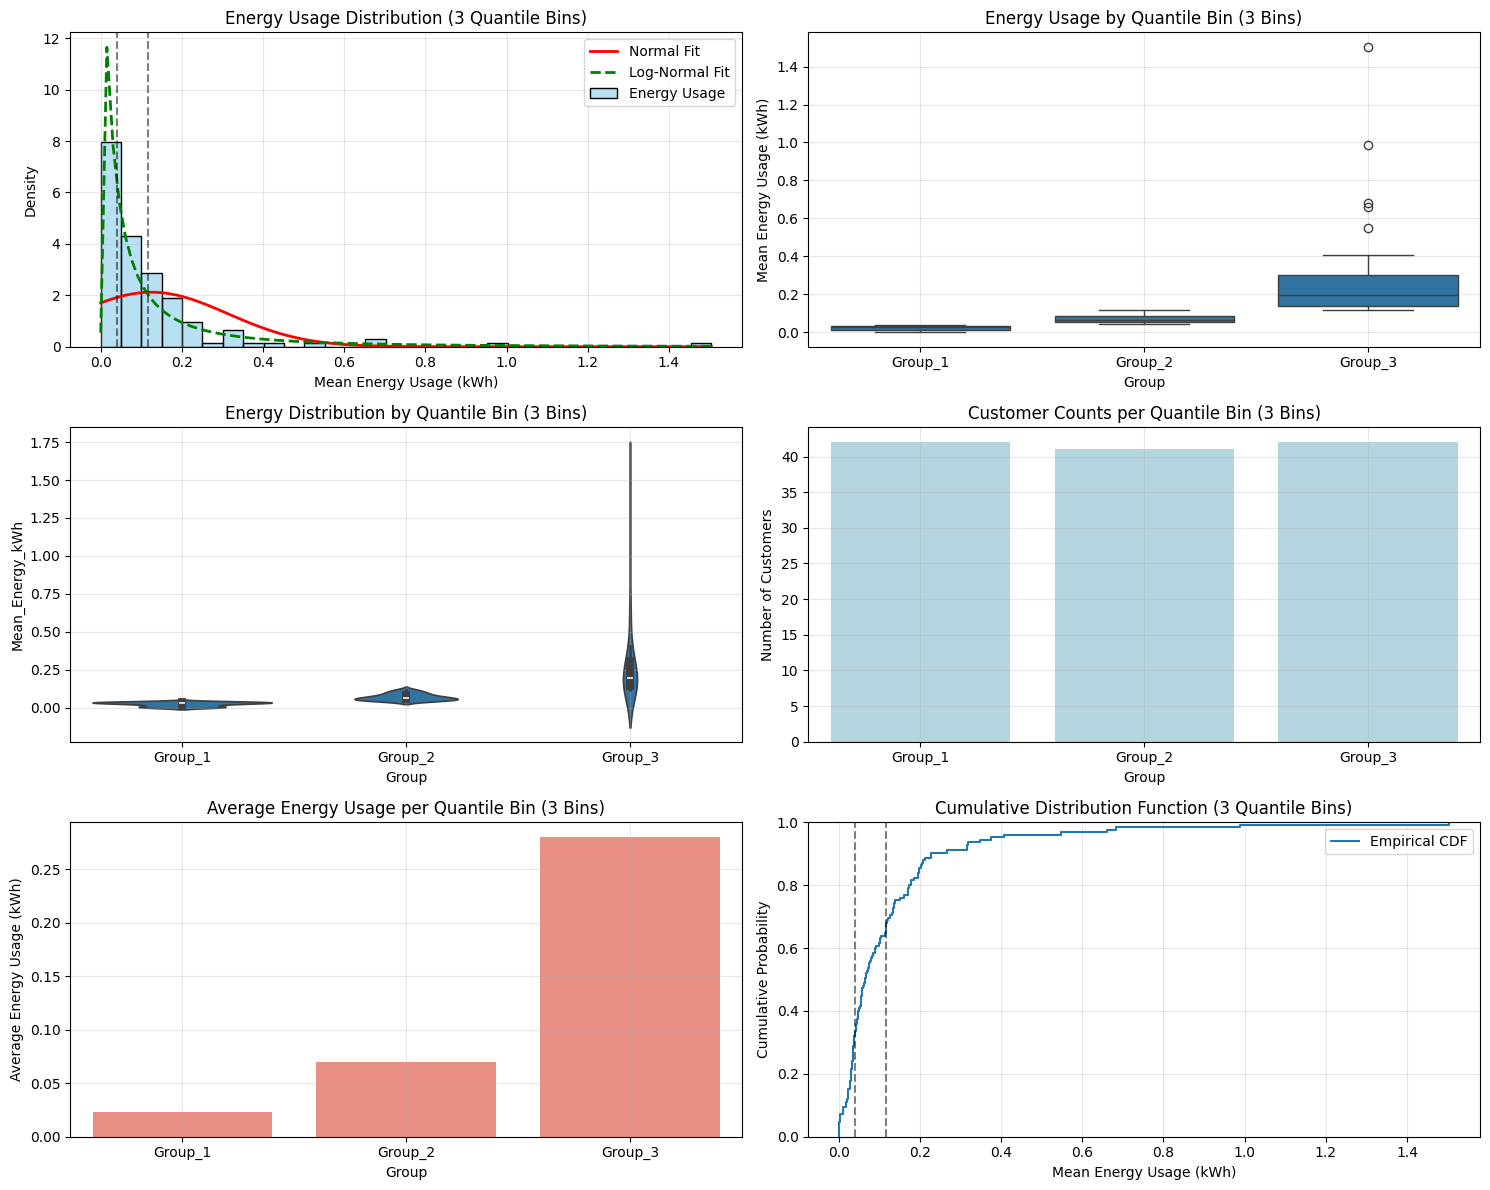

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (4 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              32        0.018794        0.000115        0.034915   
1  Group_2              31        0.047784        0.035129        0.064784   
2  Group_3              31        0.102818        0.066070        0.138858   
3  Group_4              31        0.333616        0.150236        1.504711   

   Std_Energy_kWh        CV  
0        0.012642  0.672629  
1        0.009446  0.197686  
2        0.023953  0.232964  
3        0.288012  0.863303  
Quantile thresholds: Q25: 0.0349 kWh, Q50: 0.0648 kWh, Q75: 0.1389 kWh
Average T-test P-value: 0.0000


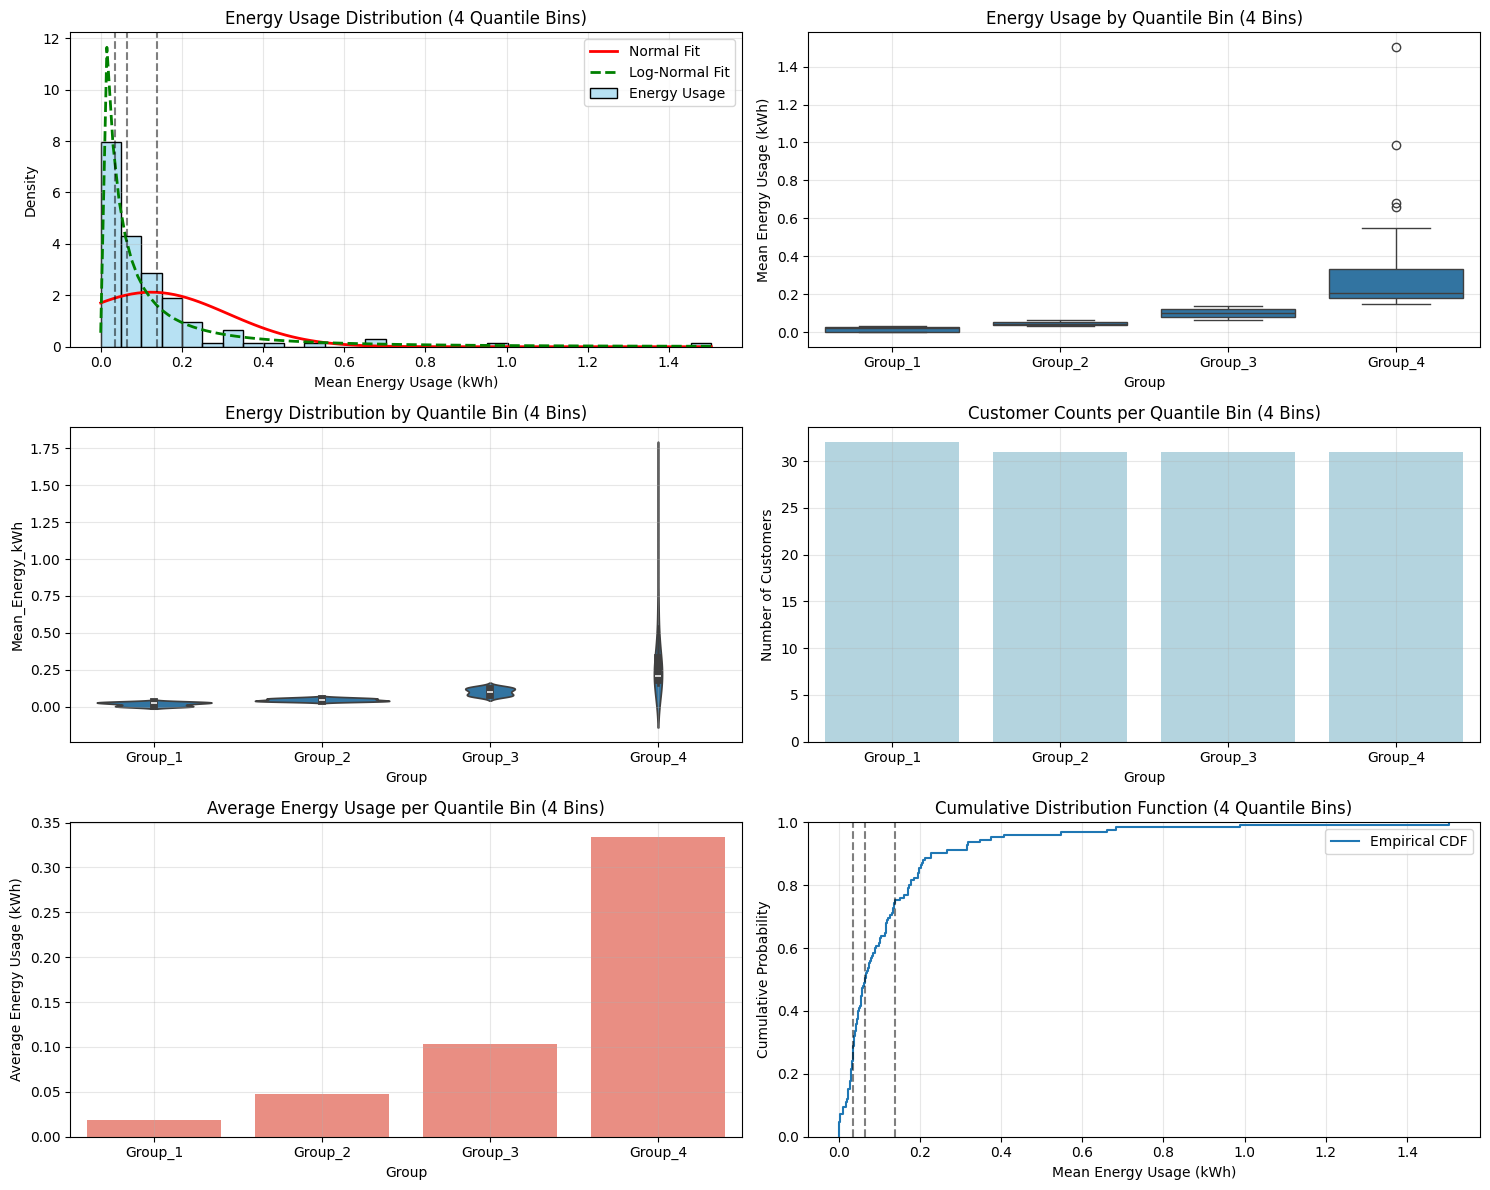

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (5 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              25        0.014840        0.000115        0.031146   
1  Group_2              25        0.038547        0.031275        0.047624   
2  Group_3              25        0.066950        0.050864        0.090301   
3  Group_4              25        0.130292        0.092925        0.172334   
4  Group_5              25        0.373858        0.177034        1.504711   

   Std_Energy_kWh        CV  
0        0.011462  0.772363  
1        0.005206  0.135069  
2        0.011800  0.176247  
3        0.024155  0.185388  
4        0.308150  0.824244  
Quantile thresholds: Q20: 0.0312 kWh, Q40: 0.0496 kWh, Q60: 0.0914 kWh, Q80: 0.1733 kWh
Average T-test P-value: 0.0001


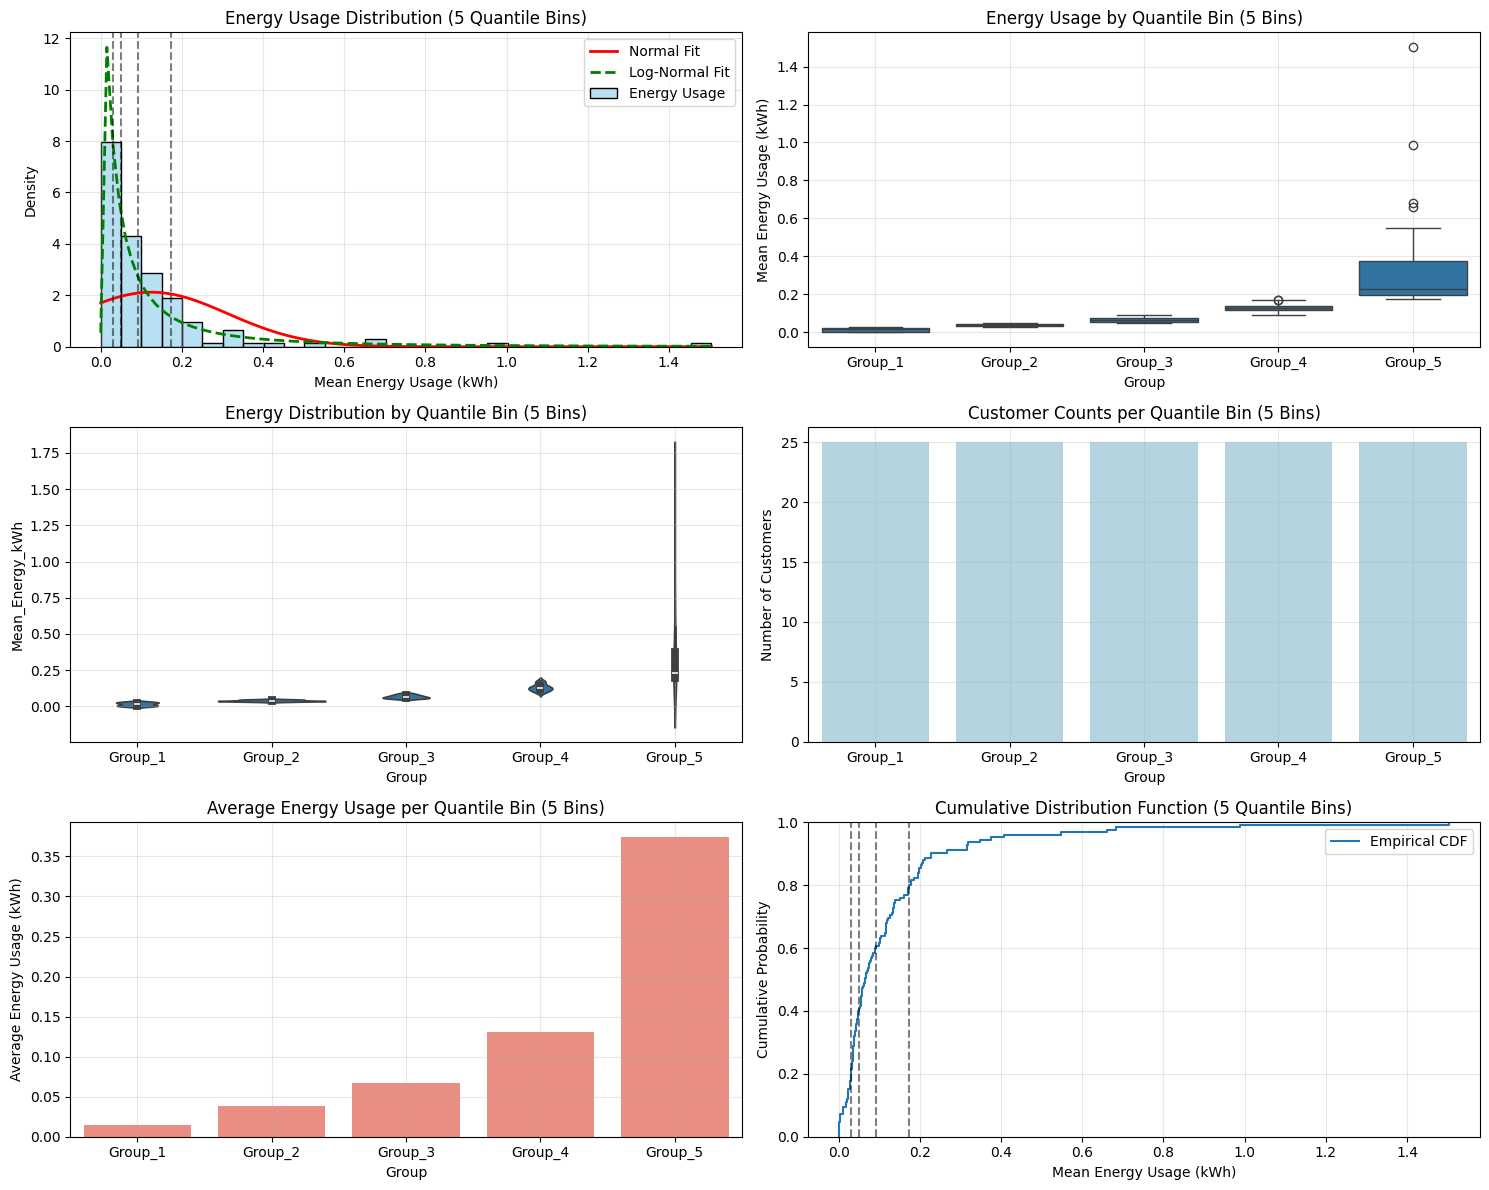

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (6 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              21        0.011937        0.000115        0.027473   
1  Group_2              21        0.034422        0.028789        0.040308   
2  Group_3              21        0.052818        0.043335        0.064784   
3  Group_4              20        0.088681        0.066070        0.117100   
4  Group_5              21        0.149789        0.117432        0.195338   
5  Group_6              21        0.410012        0.195570        1.504711   

   Std_Energy_kWh        CV  
0        0.010107  0.846689  
1        0.003264  0.094827  
2        0.007076  0.133964  
3        0.016708  0.188406  
4        0.024992  0.166849  
5        0.324590  0.791661  
Quantile thresholds: Q16: 0.0283 kWh, Q33: 0.0413 kWh, Q50: 0.0648 kWh, Q66: 0.1173 kWh, Q83: 0.1954 kWh
Average T-test P-value: 0.0001


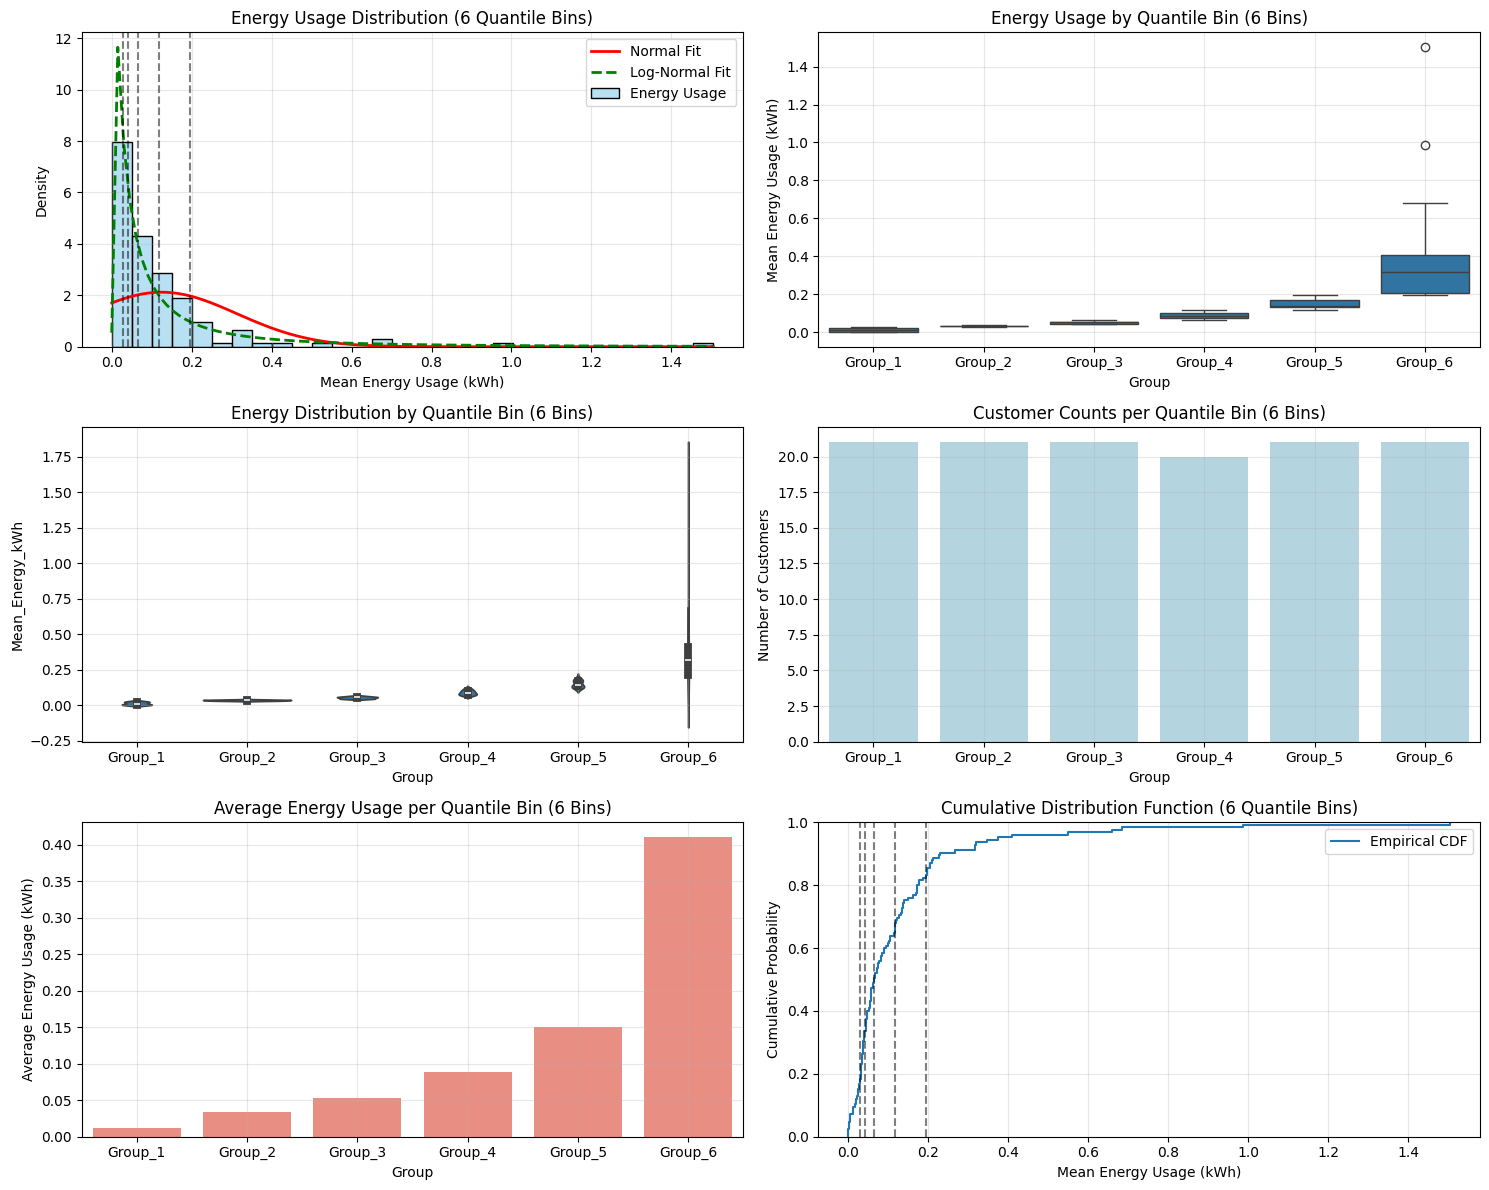

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (7 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              18        0.009607        0.000115        0.023559   
1  Group_2              18        0.031713        0.023679        0.036023   
2  Group_3              18        0.044672        0.036596        0.054965   
3  Group_4              17        0.065586        0.055799        0.080621   
4  Group_5              18        0.107175        0.081507        0.131978   
5  Group_6              18        0.166665        0.133430        0.197702   
6  Group_7              18        0.445567        0.203706        1.504711   

   Std_Energy_kWh        CV  
0        0.008916  0.928022  
1        0.003498  0.110306  
2        0.005863  0.131254  
3        0.007873  0.120046  
4        0.015267  0.142449  
5        0.023477  0.140863  
6        0.338499  0.759705  
Quantile thresholds: Q14: 0.0236 kWh, Q28: 0.0363 kWh, Q42: 0.0551 kWh, Q57: 0.0

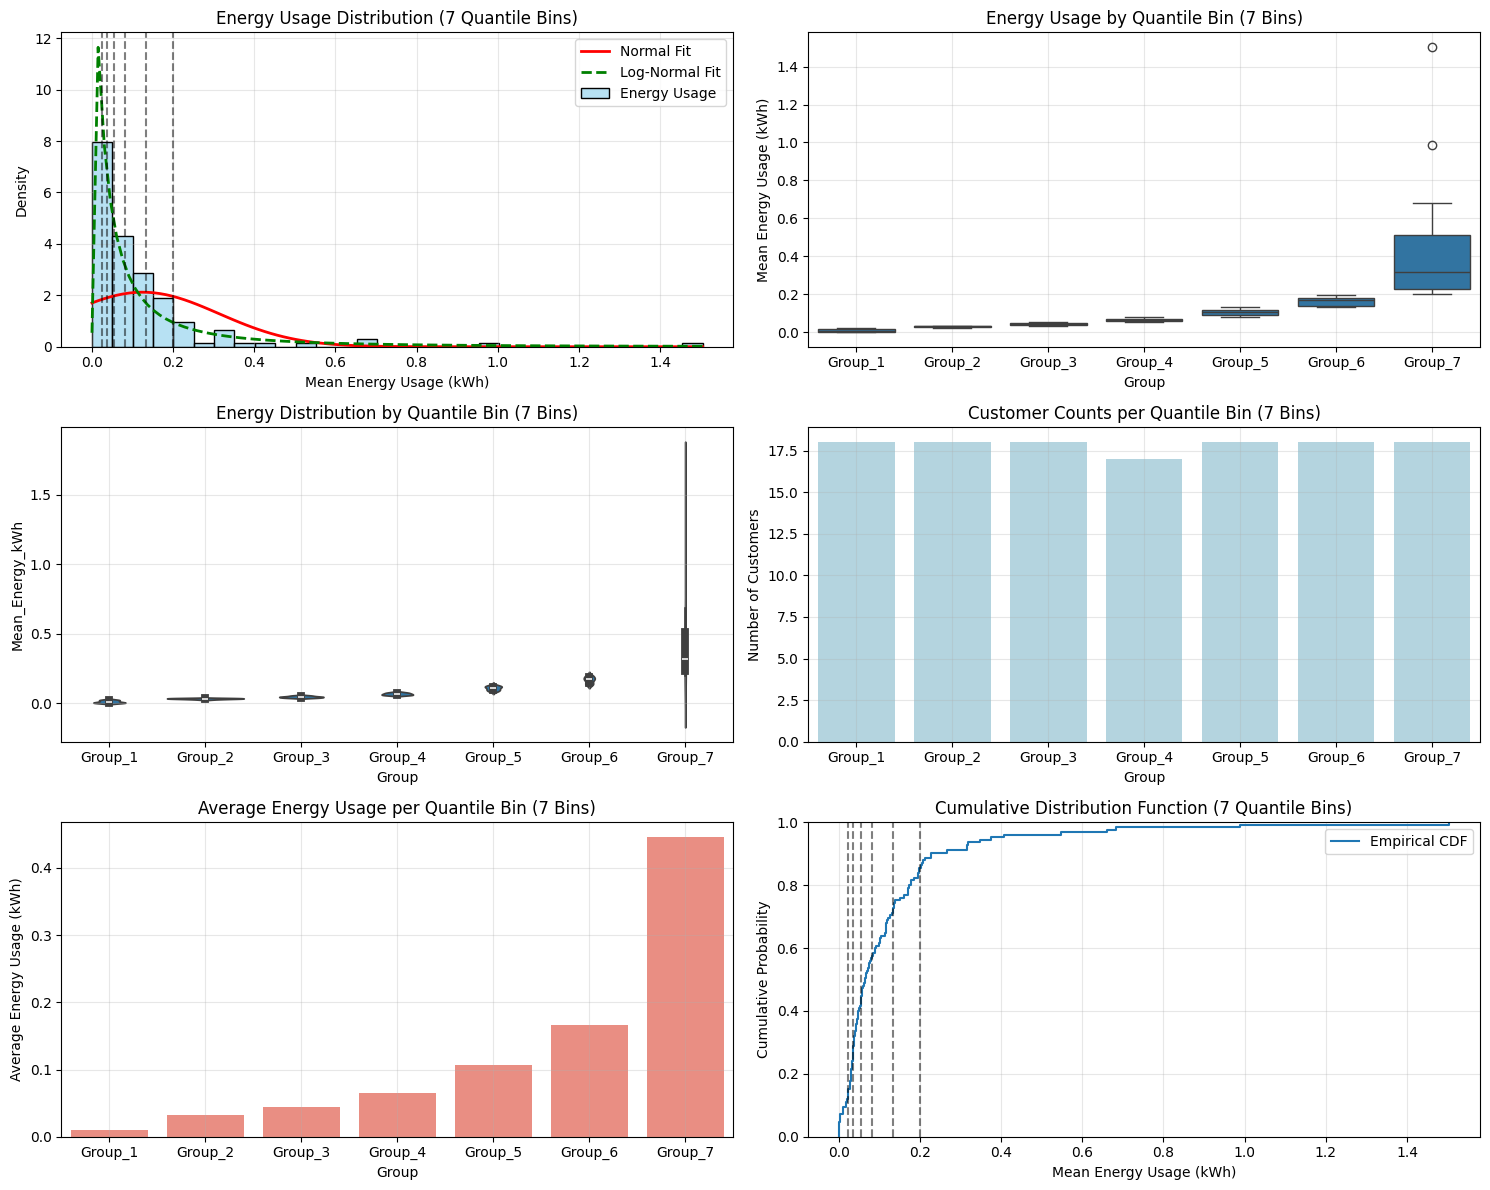

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (8 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              16        0.007903        0.000115        0.021982   
1  Group_2              16        0.029685        0.022920        0.034915   
2  Group_3              15        0.039437        0.035129        0.044777   
3  Group_4              16        0.055609        0.046735        0.064784   
4  Group_5              15        0.081232        0.066070        0.100830   
5  Group_6              16        0.123054        0.102949        0.138858   
6  Group_7              15        0.181990        0.150236        0.204257   
7  Group_8              16        0.475765        0.208856        1.504711   

   Std_Energy_kWh        CV  
0        0.007887  0.997913  
1        0.003877  0.130613  
2        0.003549  0.089998  
3        0.005632  0.101277  
4        0.011234  0.138298  
5        0.011266  0.091554  
6        0.016457  0.090430  
7 

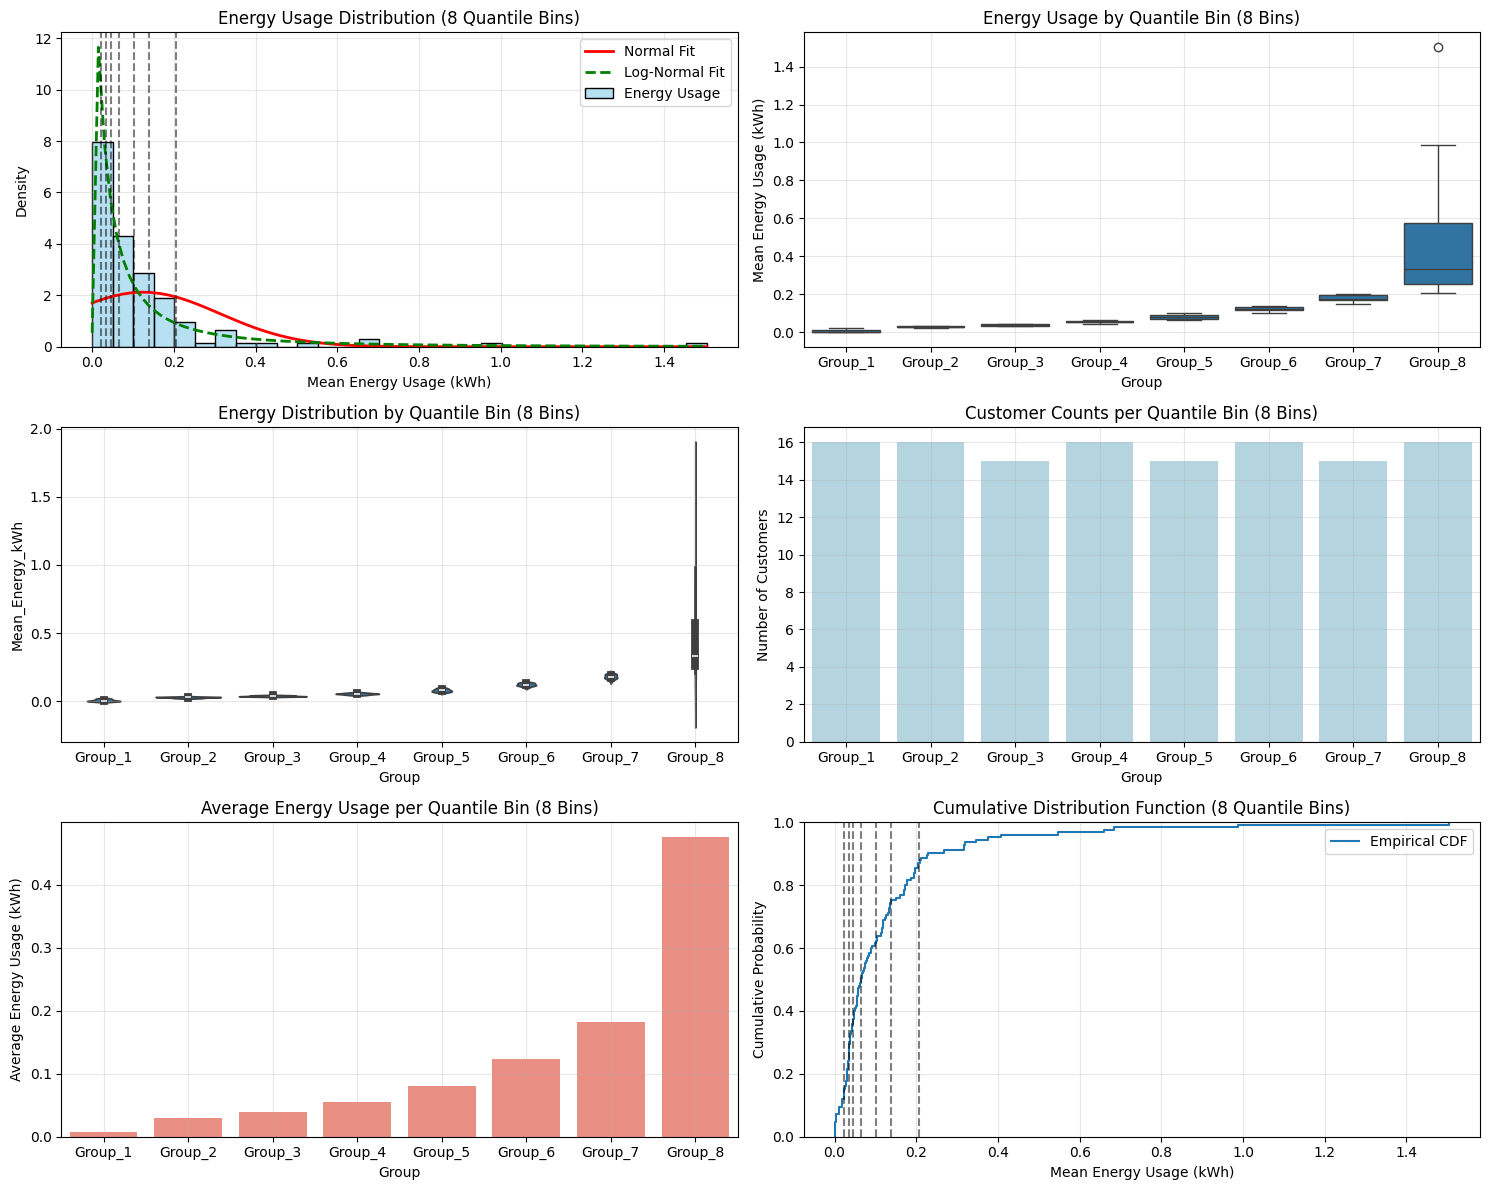

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (9 bins - Equal-sized groups):
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              14        0.006085        0.000115        0.019125   
1  Group_2              14        0.027176        0.019281        0.031922   
2  Group_3              14        0.036277        0.032529        0.040308   
3  Group_4              14        0.049019        0.043335        0.056133   
4  Group_5              13        0.065100        0.056556        0.074340   
5  Group_6              14        0.096444        0.076104        0.117100   
6  Group_7              14        0.135289        0.117432        0.169655   
7  Group_8              14        0.190770        0.171189        0.212393   
8  Group_9              14        0.513642        0.227489        1.504711   

   Std_Energy_kWh        CV  
0        0.006558  1.077714  
1        0.004193  0.154296  
2        0.002161  0.059568  
3        0.004985  0.101692  
4        0.006

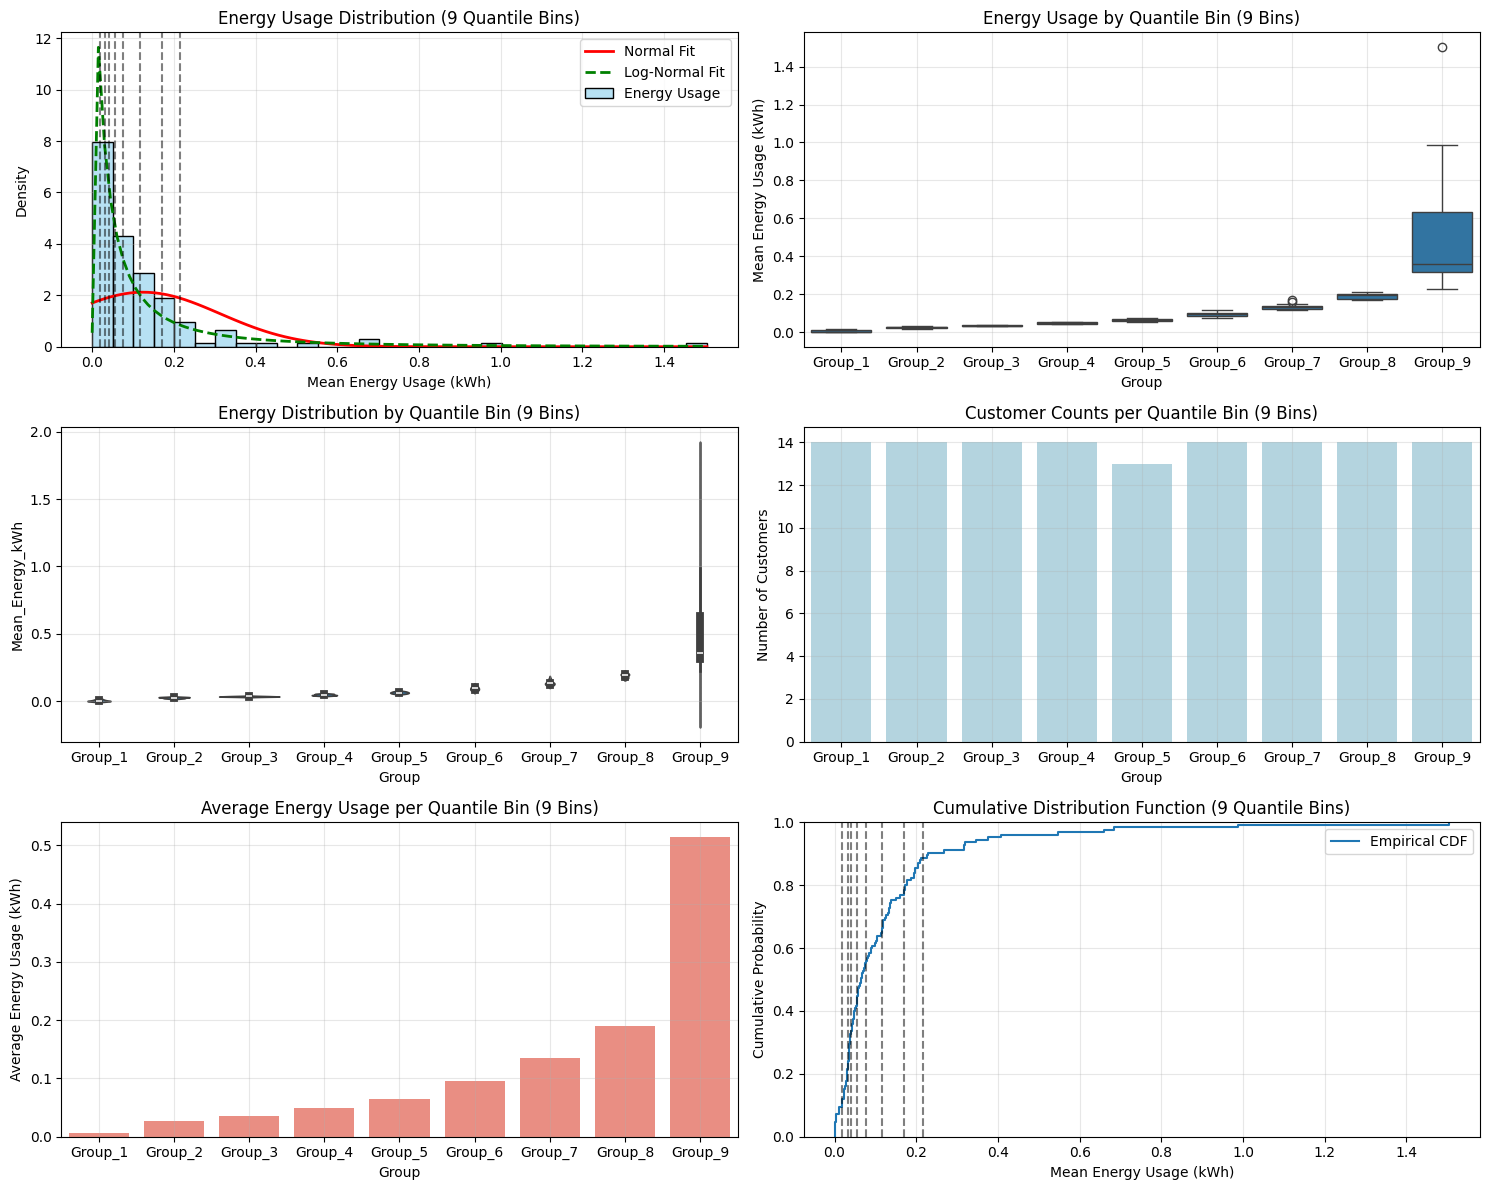

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (10 bins - Equal-sized groups):
      Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0   Group_1              13        0.005082        0.000115        0.017798   
1   Group_2              12        0.025410        0.019125        0.031146   
2   Group_3              13        0.034373        0.031275        0.037467   
3   Group_4              12        0.043068        0.038174        0.047624   
4   Group_5              13        0.057543        0.050864        0.064784   
5   Group_6              12        0.077142        0.066070        0.090301   
6   Group_7              12        0.110433        0.092925        0.122604   
7   Group_8              13        0.148623        0.126393        0.172334   
8   Group_9              12        0.198579        0.177034        0.227489   
9  Group_10              13        0.535654        0.228095        1.504711   

   Std_Energy_kWh        CV  
0        0.005597  1.101415  
1        0.004

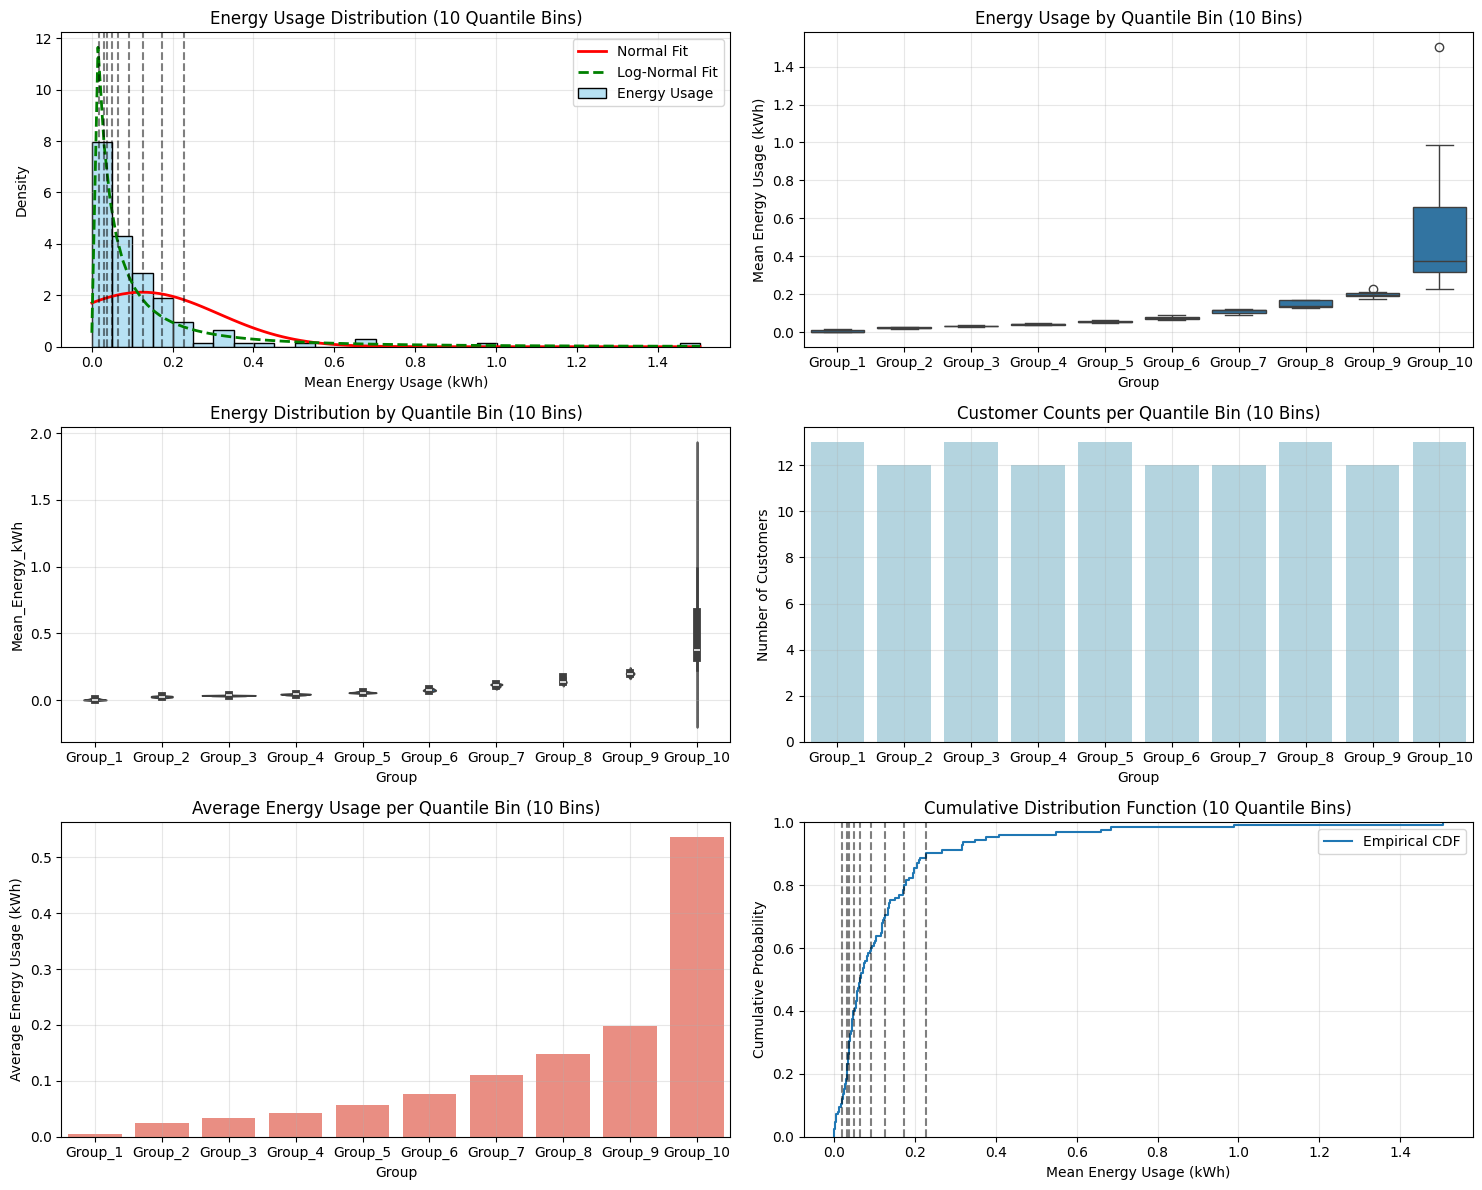

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (11 bins - Equal-sized groups):
       Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0    Group_1              12        0.004022        0.000115        0.010693   
1    Group_2              11        0.023695        0.017798        0.029456   
2    Group_3              11        0.033018        0.030928        0.035567   
3    Group_4              12        0.039674        0.035642        0.044485   
4    Group_5              11        0.051652        0.044777        0.056556   
5    Group_6              11        0.065037        0.056812        0.074170   
6    Group_7              11        0.088398        0.074340        0.102949   
7    Group_8              12        0.121247        0.103461        0.133691   
8    Group_9              11        0.160136        0.135540        0.177857   
9   Group_10              11        0.205104        0.185967        0.228095   
10  Group_11              12        0.561284        0.267506    

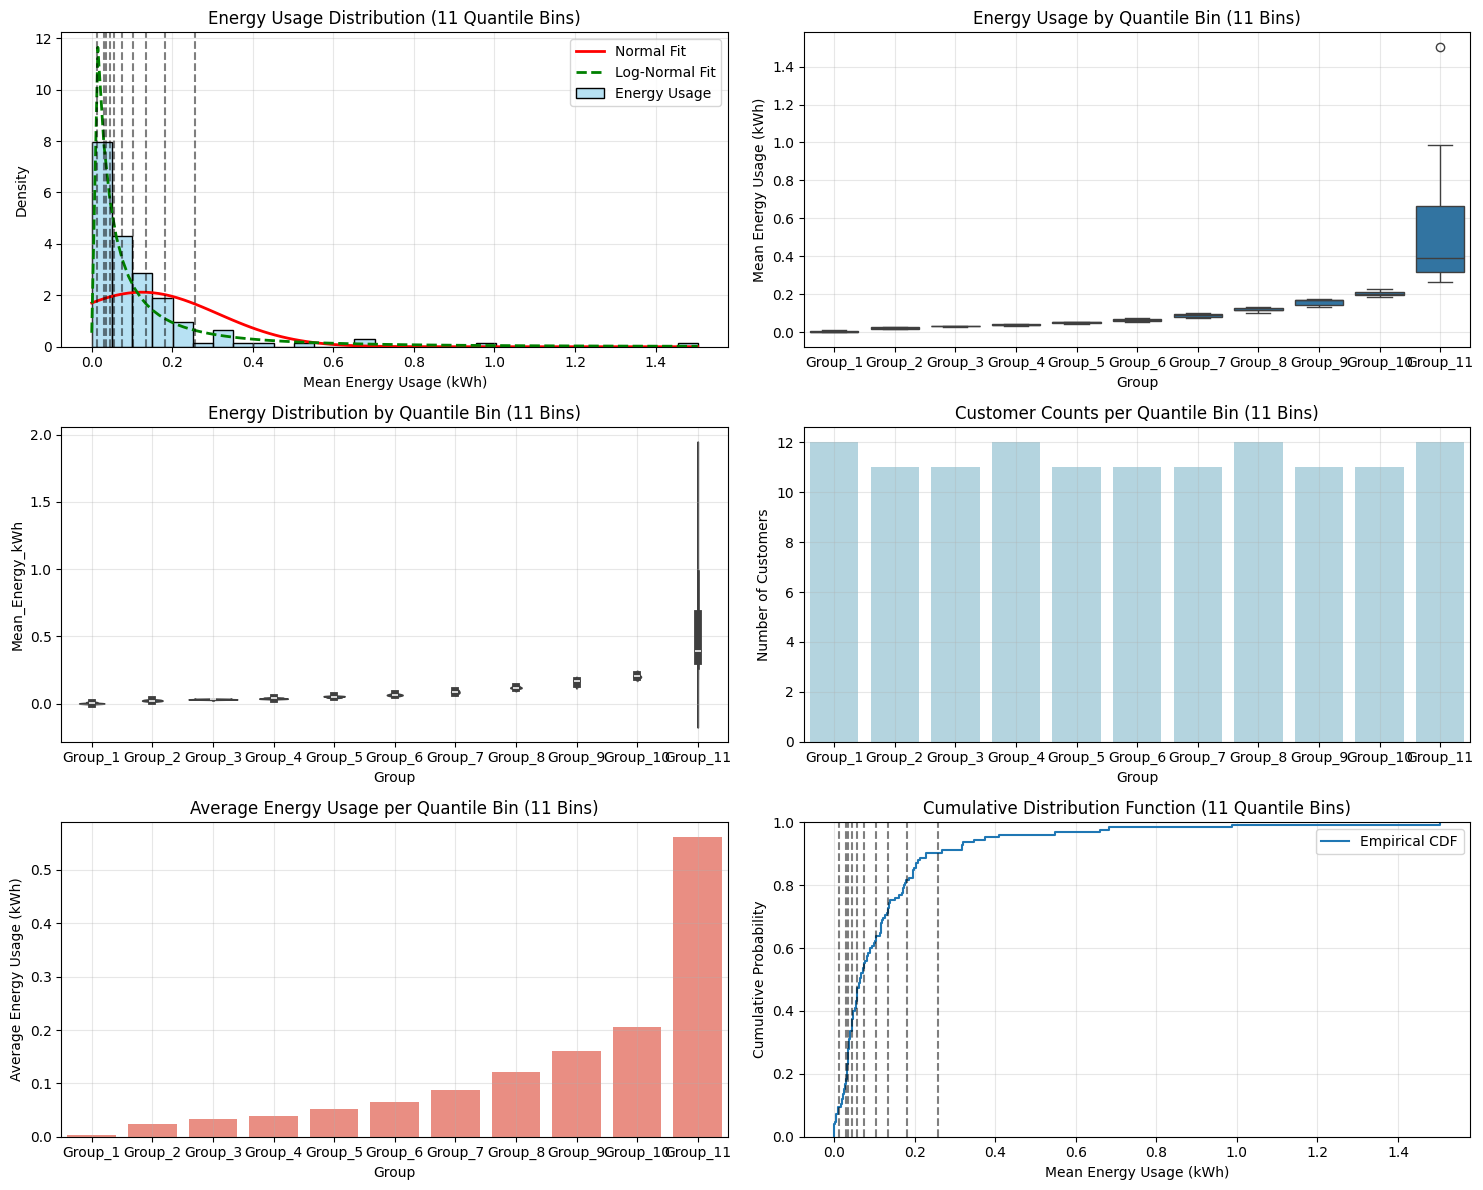

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (12 bins - Equal-sized groups):
       Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0    Group_1              11        0.003416        0.000115        0.010668   
1    Group_2              10        0.021310        0.010693        0.027473   
2    Group_3              11        0.031886        0.028789        0.034915   
3    Group_4              10        0.037213        0.035129        0.040308   
4    Group_5              10        0.046529        0.043335        0.053313   
5    Group_6              11        0.058535        0.054074        0.064784   
6    Group_7              10        0.074608        0.066070        0.084453   
7    Group_8              10        0.102754        0.089321        0.117100   
8    Group_9              11        0.128521        0.117432        0.138858   
9   Group_10              10        0.173184        0.150236        0.195338   
10  Group_11              10        0.214235        0.195570    

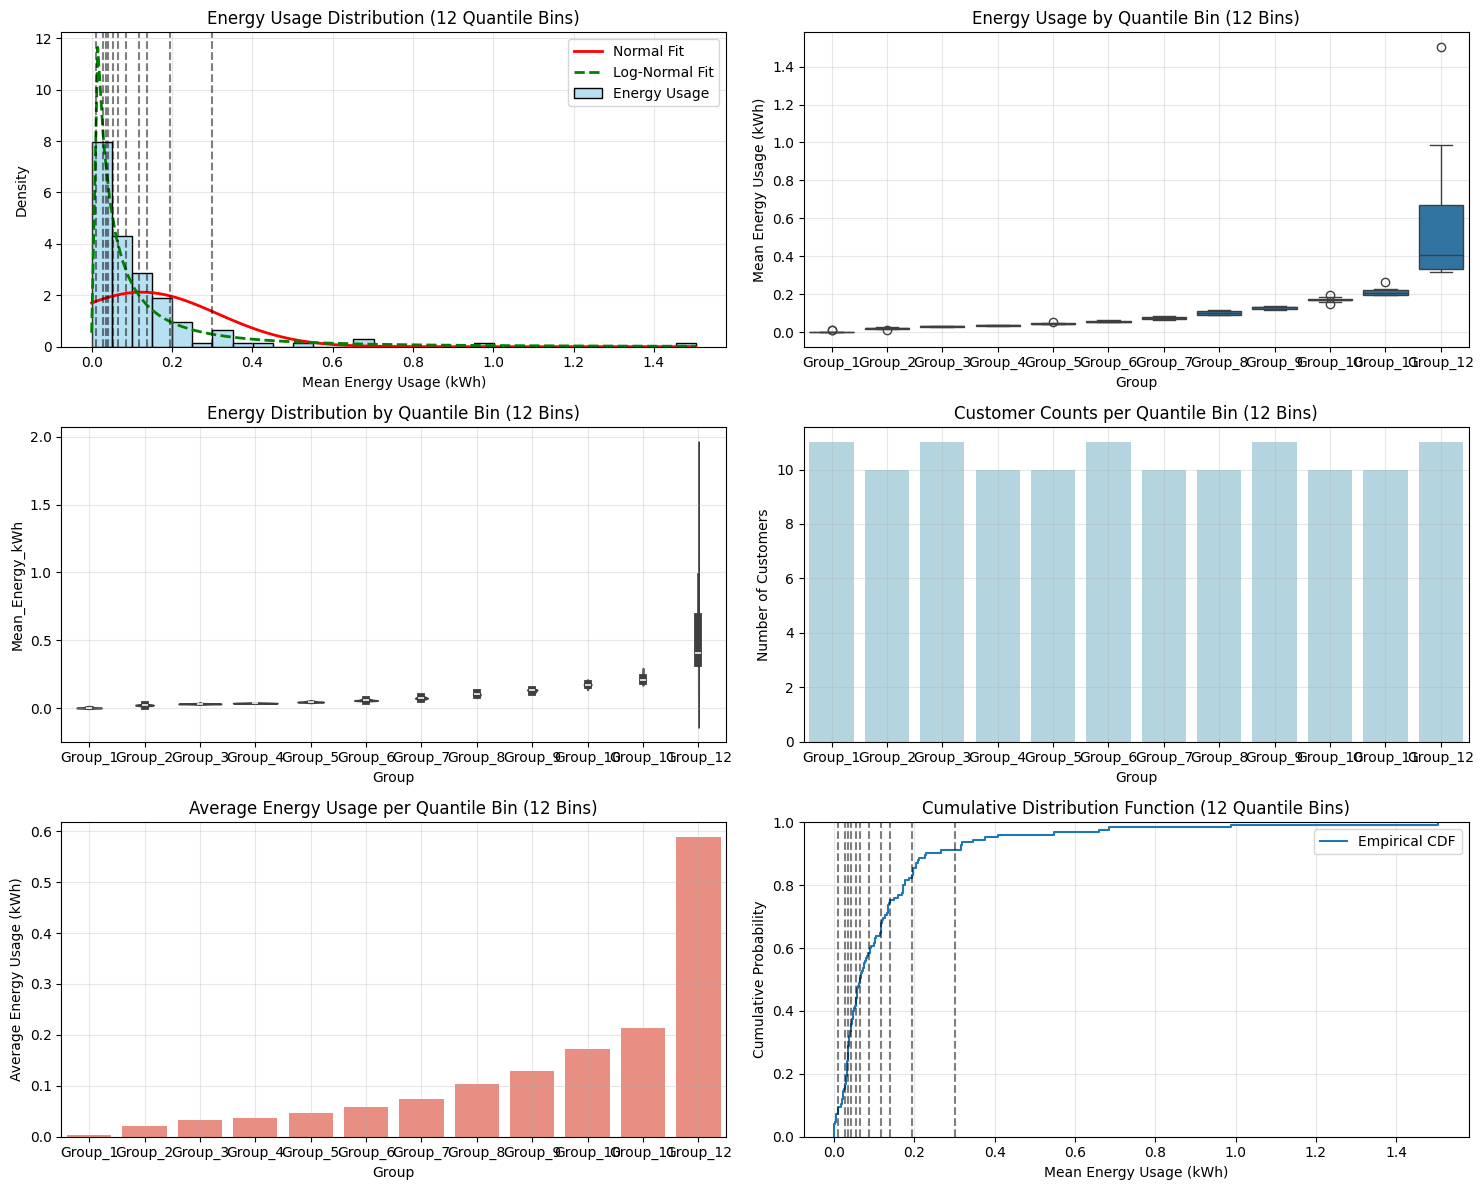

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (13 bins - Equal-sized groups):
       Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0    Group_1              10        0.002691        0.000115        0.010553   
1    Group_2              10        0.019629        0.010668        0.026586   
2    Group_3               9        0.030554        0.027473        0.032529   
3    Group_4              10        0.035782        0.033456        0.038174   
4    Group_5               9        0.042633        0.038253        0.046735   
5    Group_6              10        0.053347        0.047327        0.056812   
6    Group_7               9        0.064936        0.057732        0.071133   
7    Group_8              10        0.084276        0.074170        0.099023   
8    Group_9               9        0.112294        0.100830        0.119625   
9   Group_10              10        0.136972        0.122604        0.160433   
10  Group_11               9        0.179638        0.169655    

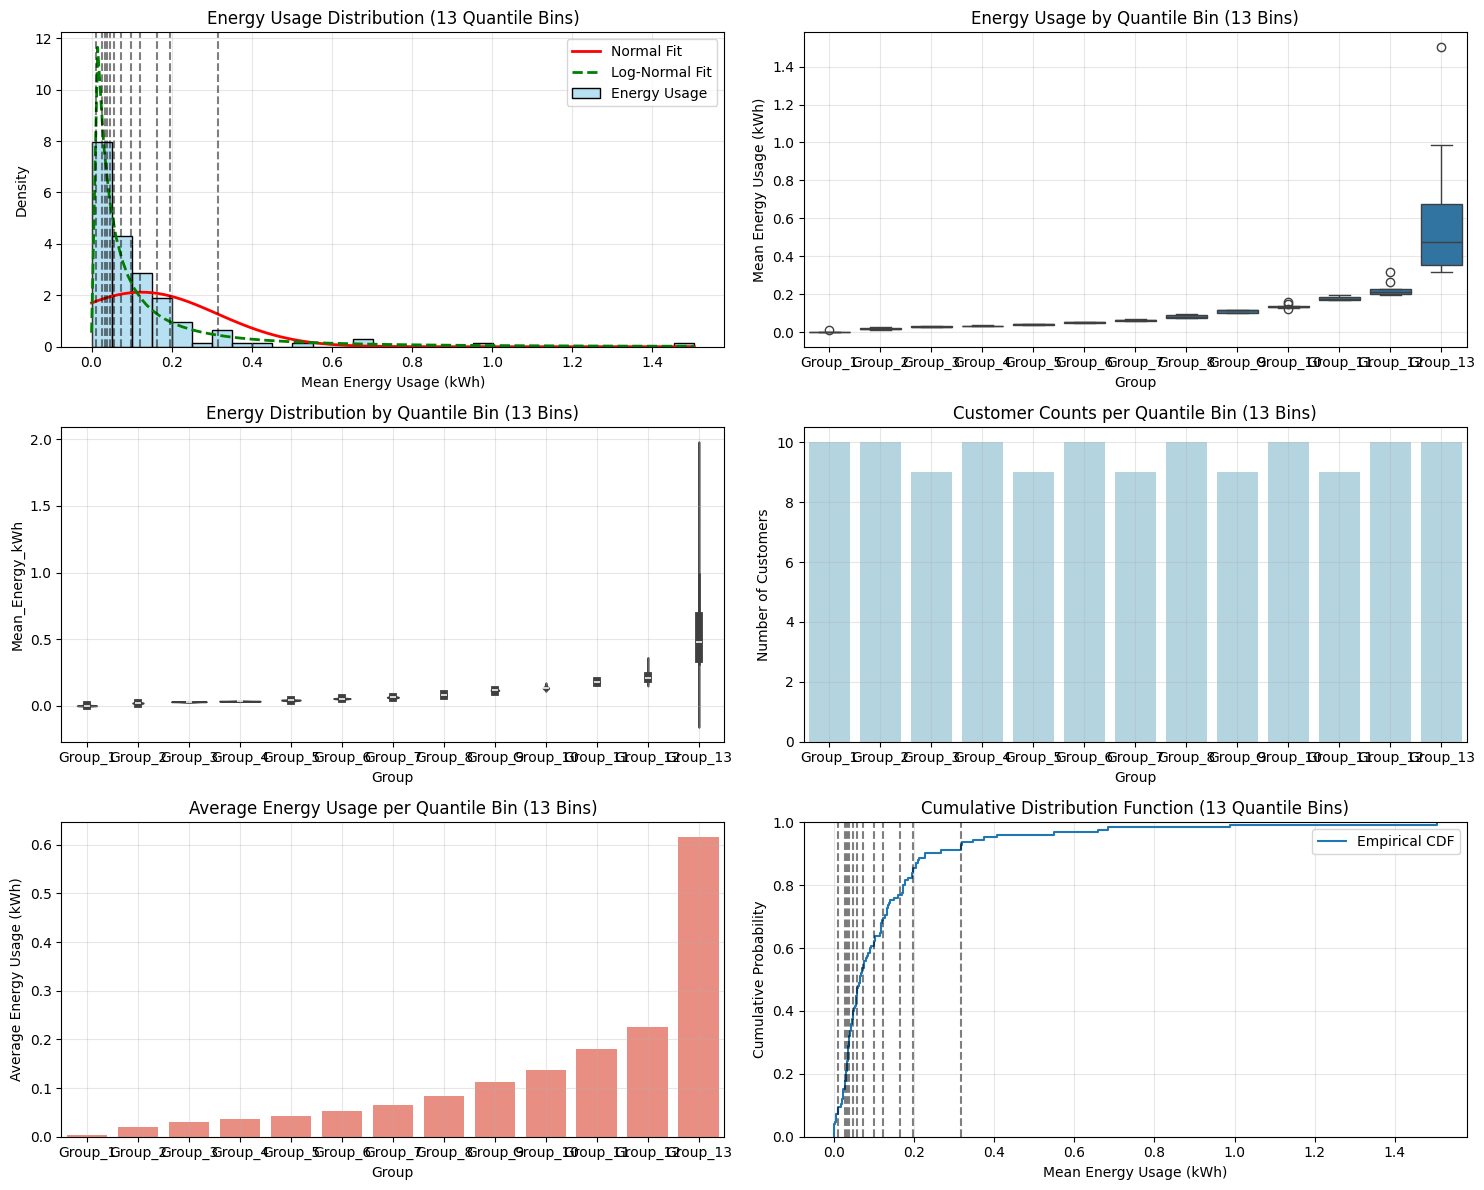

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (14 bins - Equal-sized groups):
       Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0    Group_1               9        0.001817        0.000115        0.004297   
1    Group_2               9        0.017398        0.010553        0.023559   
2    Group_3               9        0.028978        0.023679        0.031472   
3    Group_4               9        0.034448        0.031922        0.036023   
4    Group_5               9        0.039993        0.036596        0.043450   
5    Group_6               9        0.049352        0.044485        0.054965   
6    Group_7               9        0.059427        0.055799        0.064784   
7    Group_8               8        0.072515        0.066070        0.080621   
8    Group_9               9        0.093863        0.081507        0.103461   
9   Group_10               9        0.120486        0.114643        0.131978   
10  Group_11               9        0.147732        0.133430    

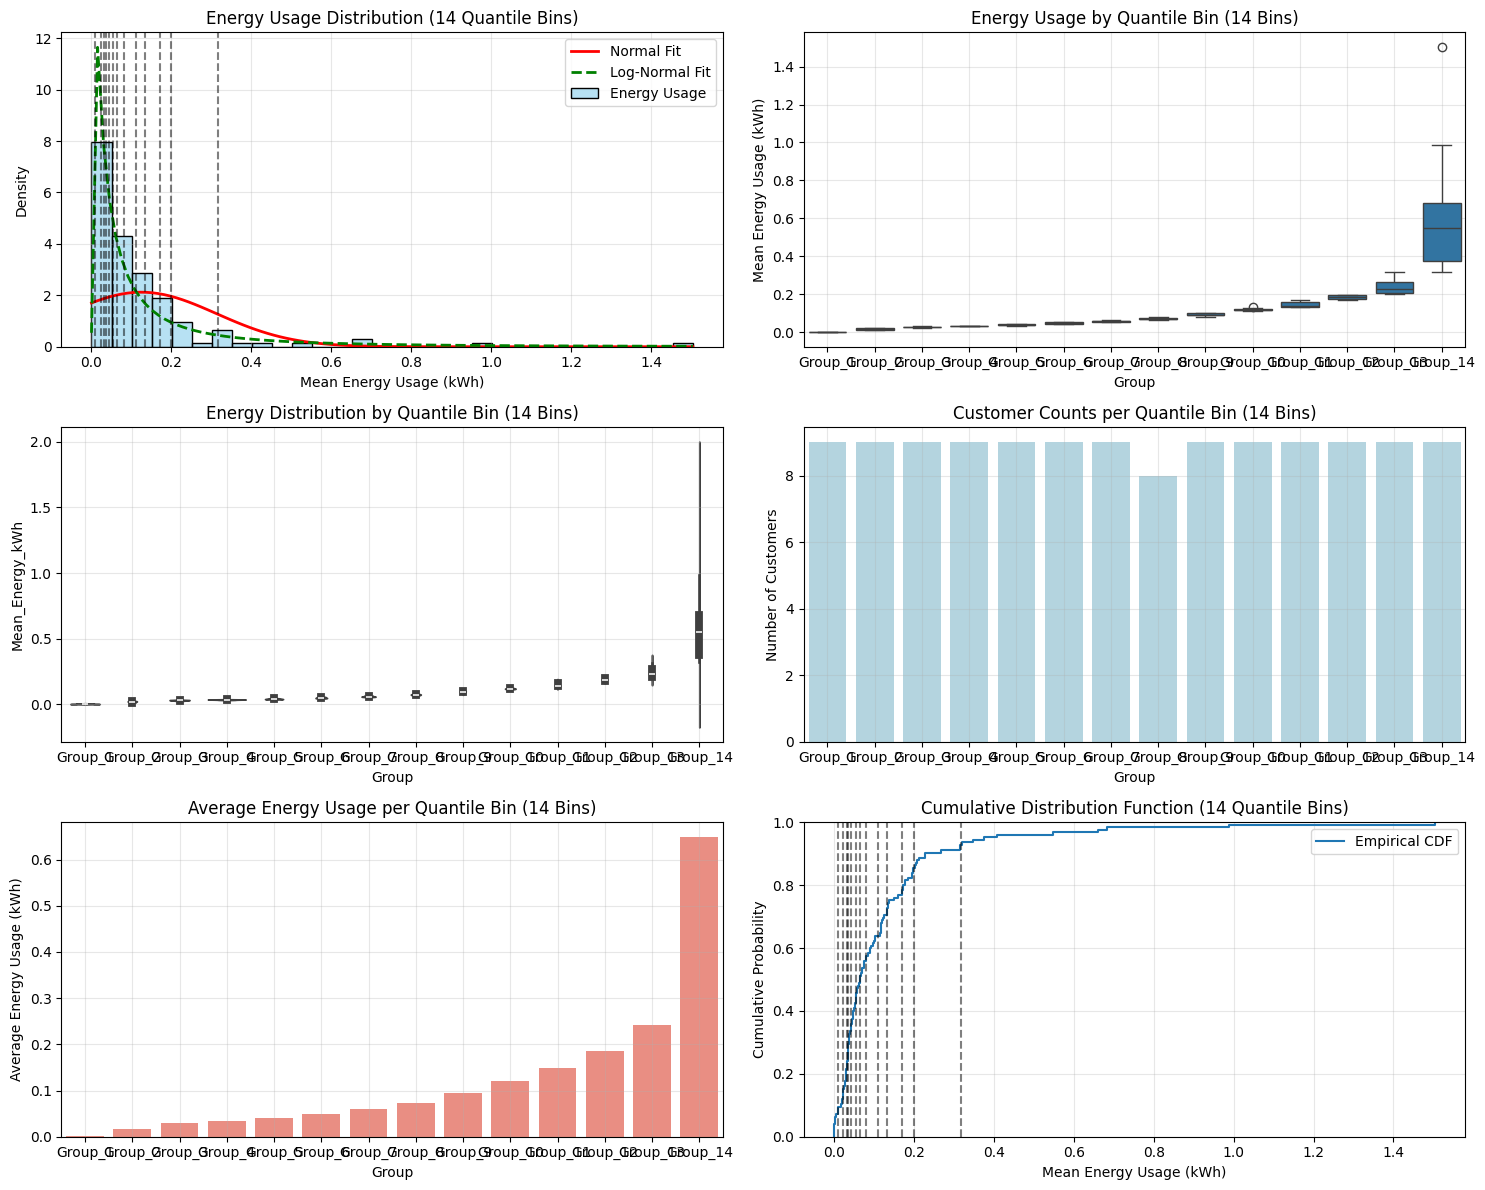

/tmp/ipython-input-3-2143723970.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(f'Quantile_{n_bins}').agg({



Quantile-Based Binning (15 bins - Equal-sized groups):
       Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0    Group_1               9        0.001817        0.000115        0.004297   
1    Group_2               8        0.016627        0.010553        0.022920   
2    Group_3               8        0.027702        0.023559        0.031146   
3    Group_4               9        0.033458        0.031275        0.035567   
4    Group_5               8        0.037679        0.035642        0.040308   
5    Group_6               8        0.045139        0.043335        0.047624   
6    Group_7               8        0.054814        0.050864        0.056812   
7    Group_8               9        0.064936        0.057732        0.071133   
8    Group_9               8        0.081352        0.074170        0.090301   
9   Group_10               8        0.105989        0.092925        0.117100   
10  Group_11               8        0.125346        0.117432    

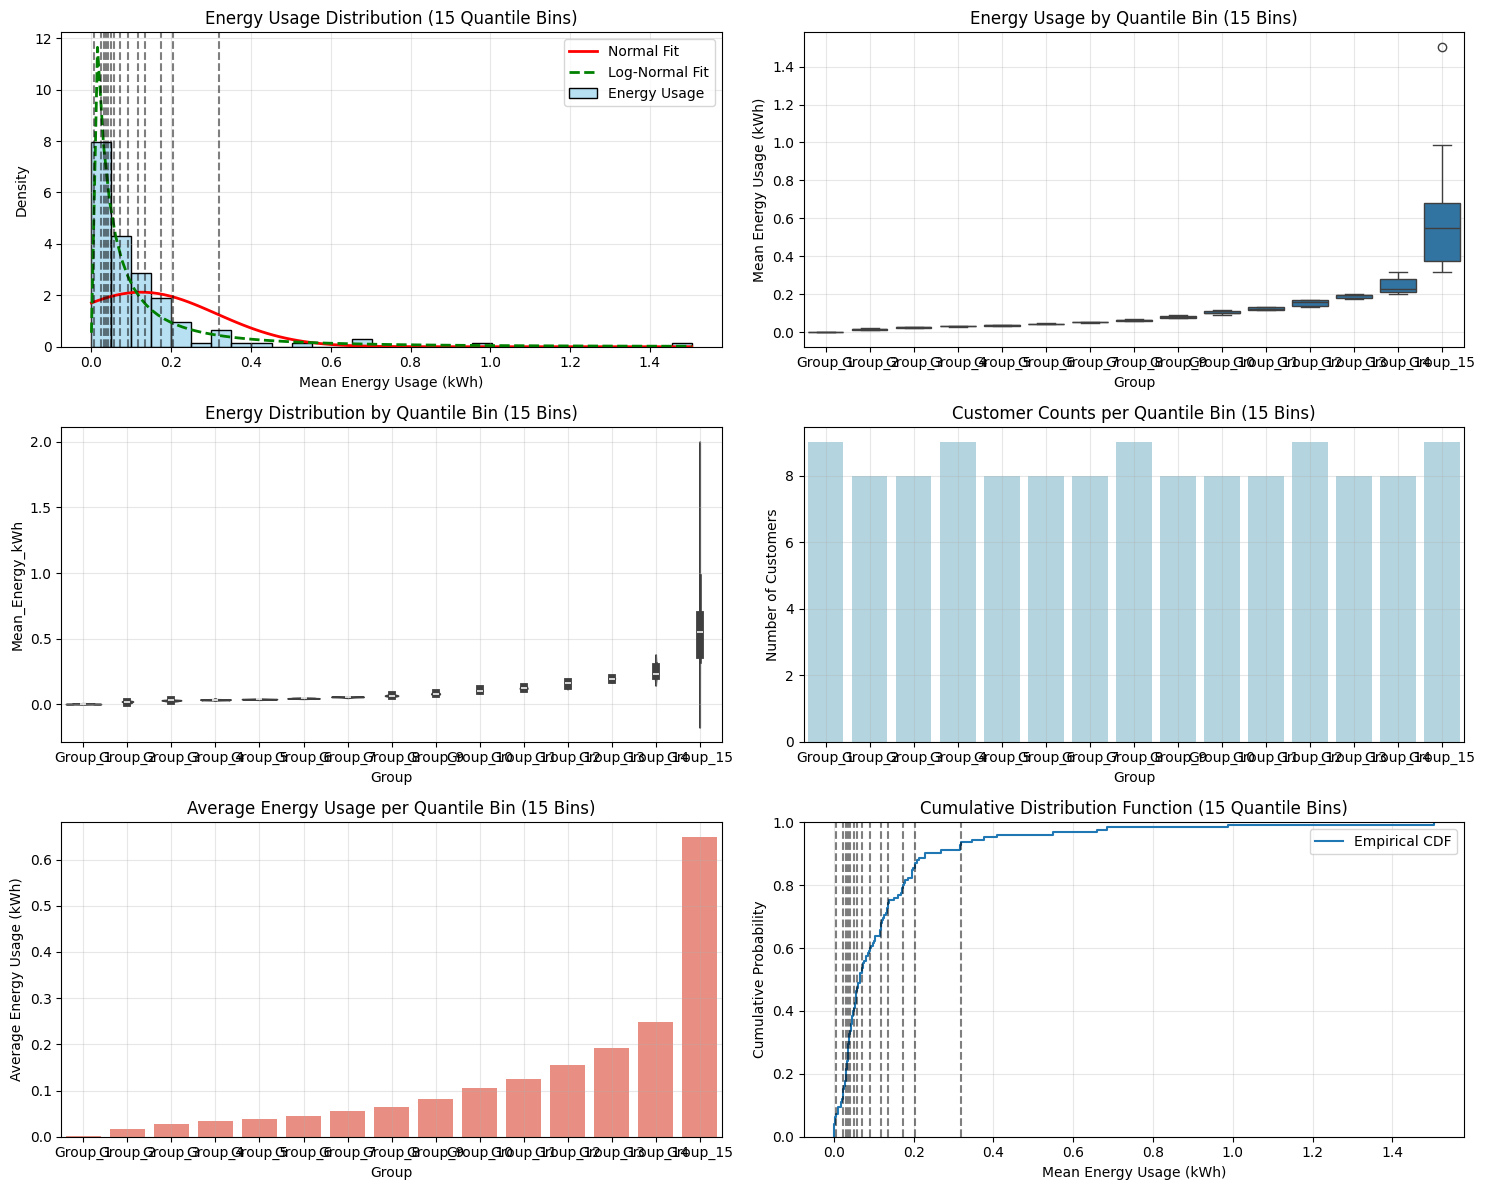

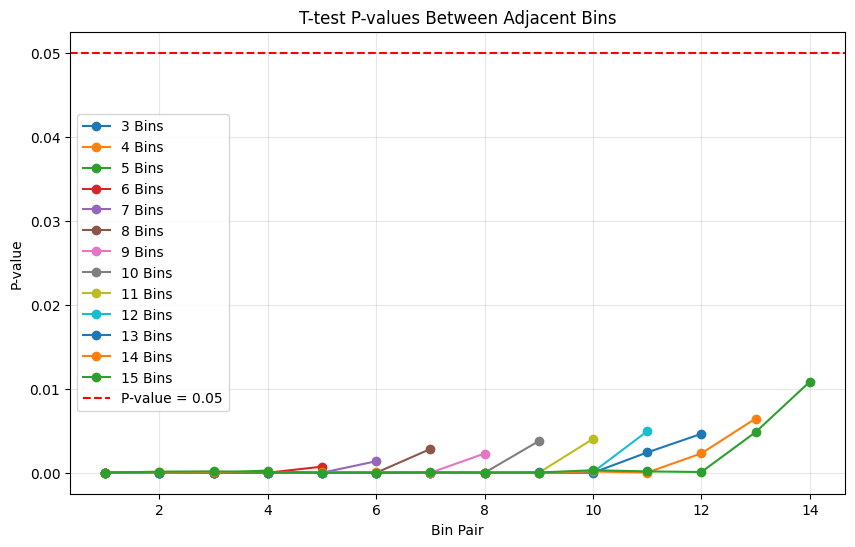


Recommended Bin Size: 3 bins (Score: 2852200.6545)
Criteria: Low CV, minimal energy range overlap, and significant t-test p-values (<0.05).

DGE-Inspired K-Means Clustering Analysis:

K-Means Clustering (3 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              39        0.195013        0.116984        0.408241   
1  Cluster_2              81        0.044719        0.000115        0.114643   
2  Cluster_3               5        0.876880        0.548185        1.504711   

   Std_Energy_kWh        CV  
0        0.076413  0.391834  
1        0.028046  0.627152  
2        0.386943  0.441273  


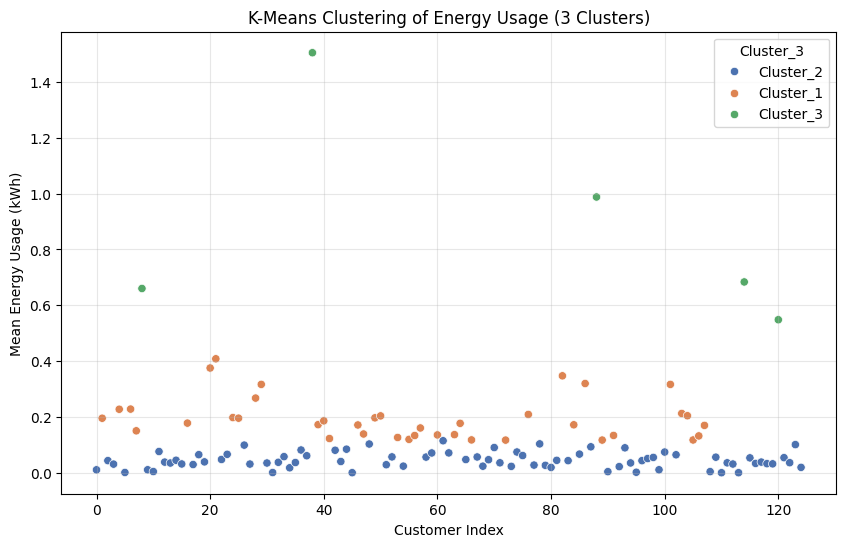


K-Means Clustering (4 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              39        0.187485        0.114643        0.375253   
1  Cluster_2              80        0.043845        0.000115        0.103461   
2  Cluster_3               5        0.657586        0.408241        0.987857   
3  Cluster_4               1        1.504711        1.504711        1.504711   

   Std_Energy_kWh        CV  
0        0.068951  0.367768  
1        0.027090  0.617851  
2        0.214418  0.326069  
3             NaN       NaN  


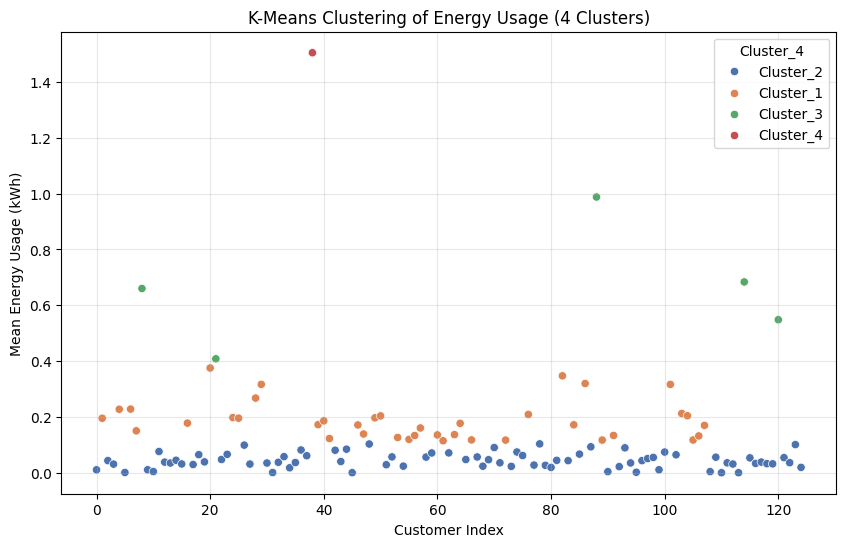


K-Means Clustering (5 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              37        0.156092        0.099023        0.228095   
1  Cluster_2              76        0.040807        0.000115        0.092925   
2  Cluster_3               4        0.719922        0.548185        0.987857   
3  Cluster_4               1        1.504711        1.504711        1.504711   
4  Cluster_5               7        0.335858        0.267506        0.408241   

   Std_Energy_kWh        CV  
0        0.039358  0.252149  
1        0.024203  0.593106  
2        0.188135  0.261327  
3             NaN       NaN  
4        0.045829  0.136454  


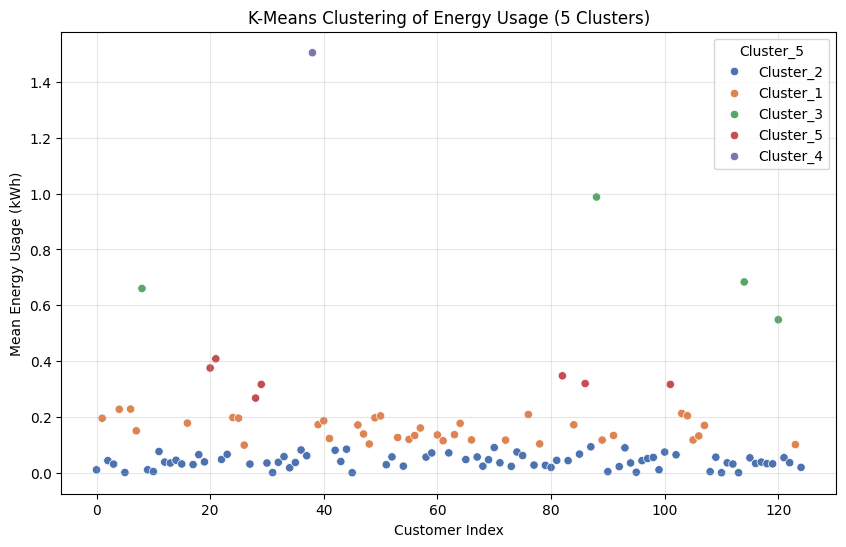


K-Means Clustering (6 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              19        0.189825        0.150236        0.228095   
1  Cluster_2              65        0.034086        0.000115        0.066792   
2  Cluster_3               4        0.719922        0.548185        0.987857   
3  Cluster_4               1        1.504711        1.504711        1.504711   
4  Cluster_5               7        0.335858        0.267506        0.408241   
5  Cluster_6              29        0.105327        0.070889        0.138858   

   Std_Energy_kWh        CV  
0        0.021689  0.114256  
1        0.018967  0.556440  
2        0.188135  0.261327  
3             NaN       NaN  
4        0.045829  0.136454  
5        0.022663  0.215169  


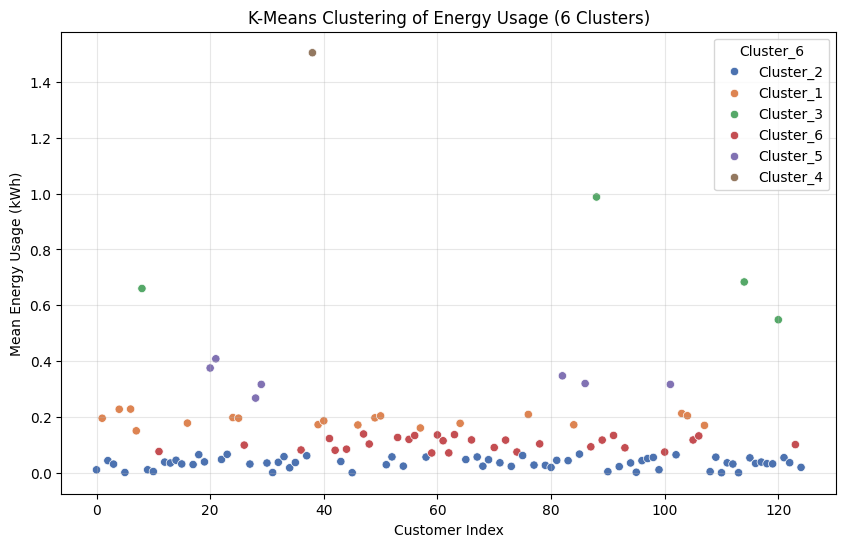


K-Means Clustering (7 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              19        0.122050        0.099023        0.150236   
1  Cluster_2              47        0.025382        0.000115        0.044777   
2  Cluster_3               4        0.719922        0.548185        0.987857   
3  Cluster_4               1        1.504711        1.504711        1.504711   
4  Cluster_5              19        0.195998        0.160433        0.267506   
5  Cluster_6              29        0.065806        0.046735        0.092925   
6  Cluster_7               6        0.347250        0.316526        0.408241   

   Std_Energy_kWh        CV  
0        0.014328  0.117390  
1        0.014358  0.565650  
2        0.188135  0.261327  
3             NaN       NaN  
4        0.026045  0.132886  
5        0.013556  0.206003  
6        0.037819  0.108909  


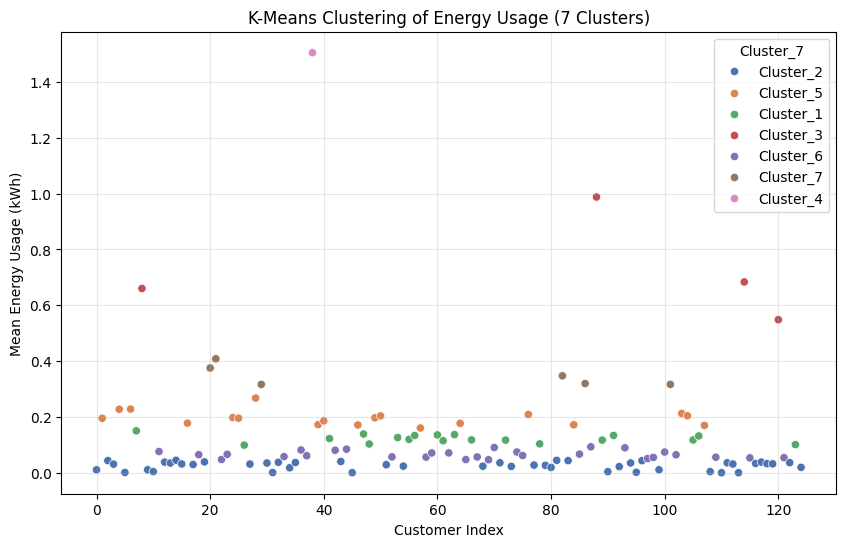


K-Means Clustering (8 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              18        0.192025        0.160433        0.228095   
1  Cluster_2              47        0.025382        0.000115        0.044777   
2  Cluster_3               3        0.630610        0.548185        0.683539   
3  Cluster_4               1        0.987857        0.987857        0.987857   
4  Cluster_5               7        0.335858        0.267506        0.408241   
5  Cluster_6              29        0.065806        0.046735        0.092925   
6  Cluster_7               1        1.504711        1.504711        1.504711   
7  Cluster_8              19        0.122050        0.099023        0.150236   

   Std_Energy_kWh        CV  
0        0.020019  0.104252  
1        0.014358  0.565650  
2        0.072337  0.114709  
3             NaN       NaN  
4        0.045829  0.136454  
5        0.013556  0.206003  
6             NaN       NaN  
7    

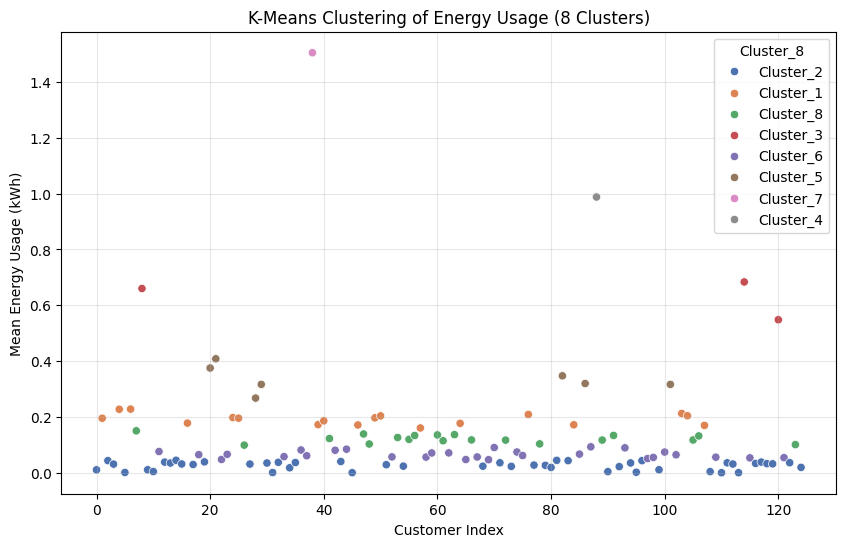


K-Means Clustering (9 clusters):
     Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Cluster_1              18        0.192025        0.160433        0.228095   
1  Cluster_2              19        0.010348        0.000115        0.023679   
2  Cluster_3               3        0.630610        0.548185        0.683539   
3  Cluster_4               1        0.987857        0.987857        0.987857   
4  Cluster_5               7        0.335858        0.267506        0.408241   
5  Cluster_6              18        0.076081        0.060939        0.099023   
6  Cluster_7               1        1.504711        1.504711        1.504711   
7  Cluster_8              18        0.123330        0.100830        0.150236   
8  Cluster_9              40        0.040857        0.026586        0.057732   

   Std_Energy_kWh        CV  
0        0.020019  0.104252  
1        0.009247  0.893556  
2        0.072337  0.114709  
3             NaN       NaN  
4        0.0458

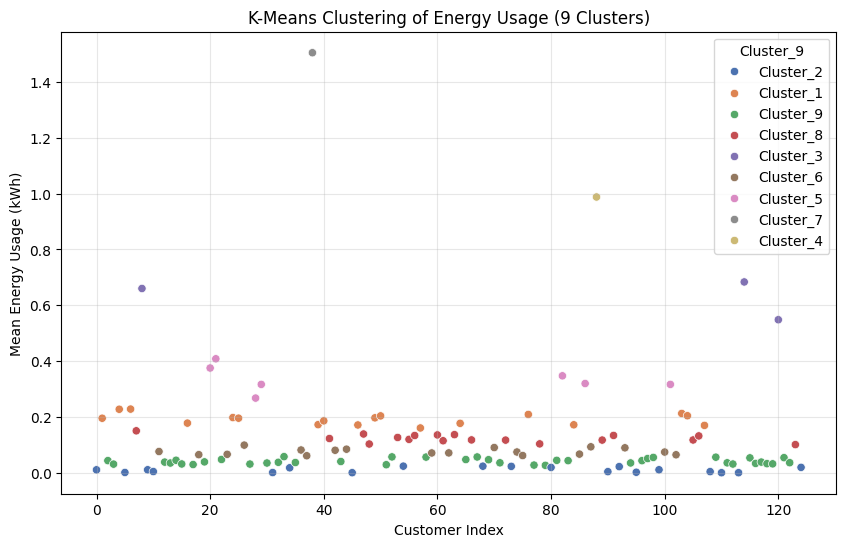


K-Means Clustering (10 clusters):
      Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0   Cluster_1              18        0.192025        0.160433        0.228095   
1  Cluster_10               1        0.548185        0.548185        0.548185   
2   Cluster_2              19        0.010348        0.000115        0.023679   
3   Cluster_3               2        0.671822        0.660106        0.683539   
4   Cluster_4               1        0.987857        0.987857        0.987857   
5   Cluster_5               7        0.335858        0.267506        0.408241   
6   Cluster_6              18        0.076081        0.060939        0.099023   
7   Cluster_7               1        1.504711        1.504711        1.504711   
8   Cluster_8              18        0.123330        0.100830        0.150236   
9   Cluster_9              40        0.040857        0.026586        0.057732   

   Std_Energy_kWh        CV  
0        0.020019  0.104252  
1            

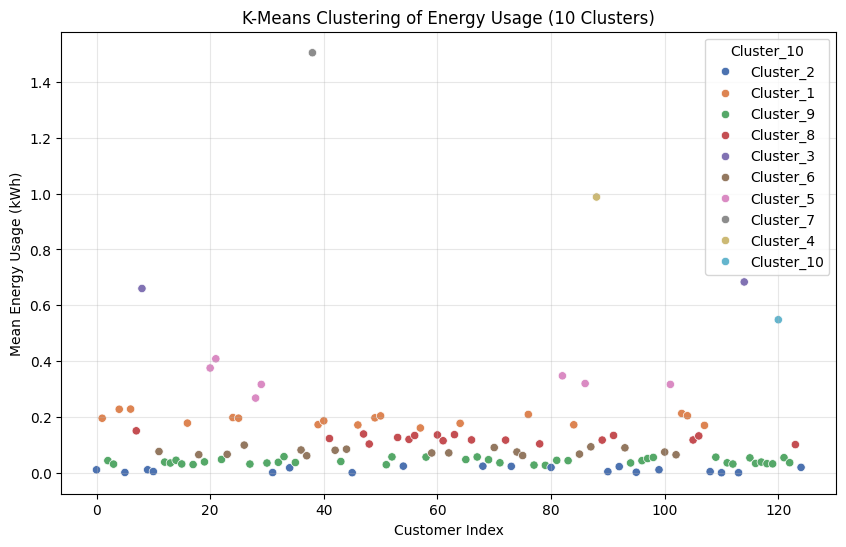


K-Means Clustering (11 clusters):
       Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  \
0    Cluster_1              13        0.178607        0.150236   
1   Cluster_10               1        0.548185        0.548185   
2   Cluster_11               7        0.221757        0.203706   
3    Cluster_2              19        0.010348        0.000115   
4    Cluster_3               2        0.671822        0.660106   
5    Cluster_4               1        0.987857        0.987857   
6    Cluster_5               6        0.347250        0.316526   
7    Cluster_6              18        0.073787        0.057732   
8    Cluster_7               1        1.504711        1.504711   
9    Cluster_8              18        0.120484        0.099023   
10   Cluster_9              39        0.040425        0.026586   

    Max_Energy_kWh  Std_Energy_kWh        CV  
0         0.197702        0.014932  0.083604  
1         0.548185             NaN       NaN  
2         0.267506        0.022

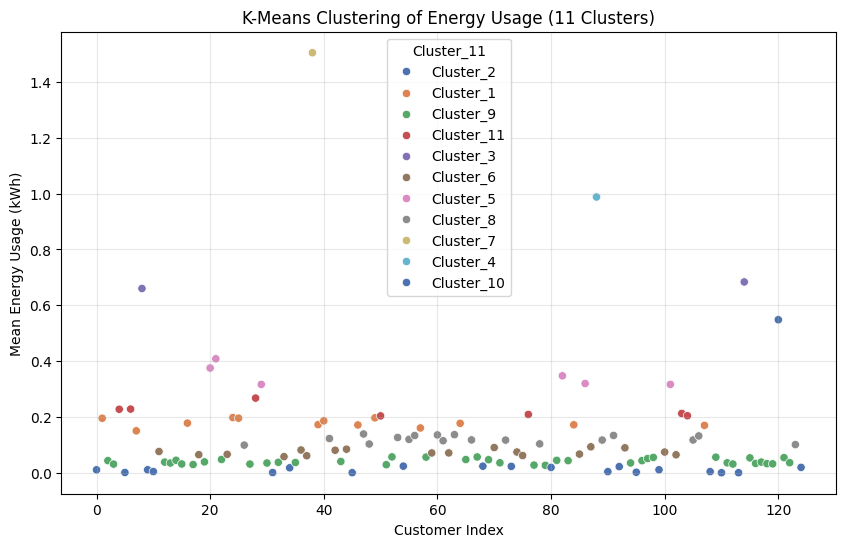


K-Means Clustering (12 clusters):
       Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  \
0    Cluster_1              13        0.178607        0.150236   
1   Cluster_10               1        0.548185        0.548185   
2   Cluster_11               7        0.221757        0.203706   
3   Cluster_12               2        0.391747        0.375253   
4    Cluster_2              19        0.010348        0.000115   
5    Cluster_3               2        0.671822        0.660106   
6    Cluster_4               1        0.987857        0.987857   
7    Cluster_5               4        0.325001        0.316526   
8    Cluster_6              18        0.073787        0.057732   
9    Cluster_7               1        1.504711        1.504711   
10   Cluster_8              18        0.120484        0.099023   
11   Cluster_9              39        0.040425        0.026586   

    Max_Energy_kWh  Std_Energy_kWh        CV  
0         0.197702        0.014932  0.083604  
1         0.

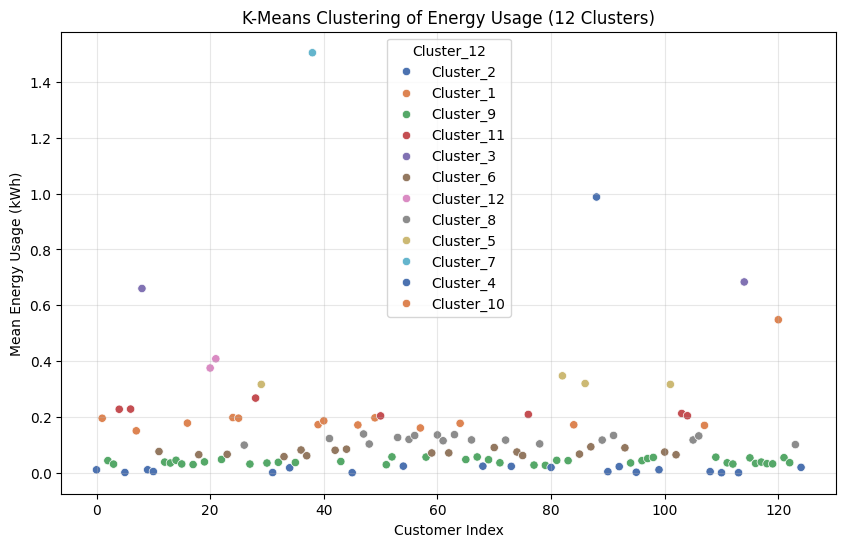


K-Means Clustering (13 clusters):
       Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  \
0    Cluster_1              12        0.180971        0.160433   
1   Cluster_10               1        0.548185        0.548185   
2   Cluster_11               7        0.221757        0.203706   
3   Cluster_12               2        0.391747        0.375253   
4   Cluster_13              20        0.058232        0.046735   
5    Cluster_2              15        0.006965        0.000115   
6    Cluster_3               2        0.671822        0.660106   
7    Cluster_4               1        0.987857        0.987857   
8    Cluster_5               4        0.325001        0.316526   
9    Cluster_6              13        0.088462        0.074170   
10   Cluster_7               1        1.504711        1.504711   
11   Cluster_8              15        0.127513        0.114643   
12   Cluster_9              32        0.034016        0.021982   

    Max_Energy_kWh  Std_Energy_kWh      

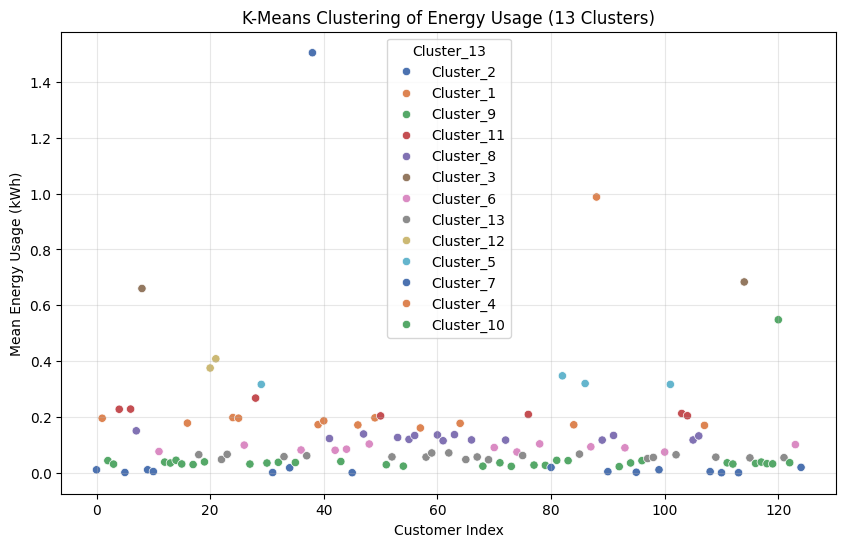


K-Means Clustering (14 clusters):
       Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  \
0    Cluster_1              12        0.180971        0.160433   
1   Cluster_10               1        0.548185        0.548185   
2   Cluster_11               7        0.221757        0.203706   
3   Cluster_12               2        0.391747        0.375253   
4   Cluster_13              20        0.062378        0.050864   
5   Cluster_14              12        0.004022        0.000115   
6    Cluster_2              11        0.023695        0.017798   
7    Cluster_3               2        0.671822        0.660106   
8    Cluster_4               1        0.987857        0.987857   
9    Cluster_5               4        0.325001        0.316526   
10   Cluster_6              10        0.092539        0.080621   
11   Cluster_7               1        1.504711        1.504711   
12   Cluster_8              15        0.127513        0.114643   
13   Cluster_9              27        0.0

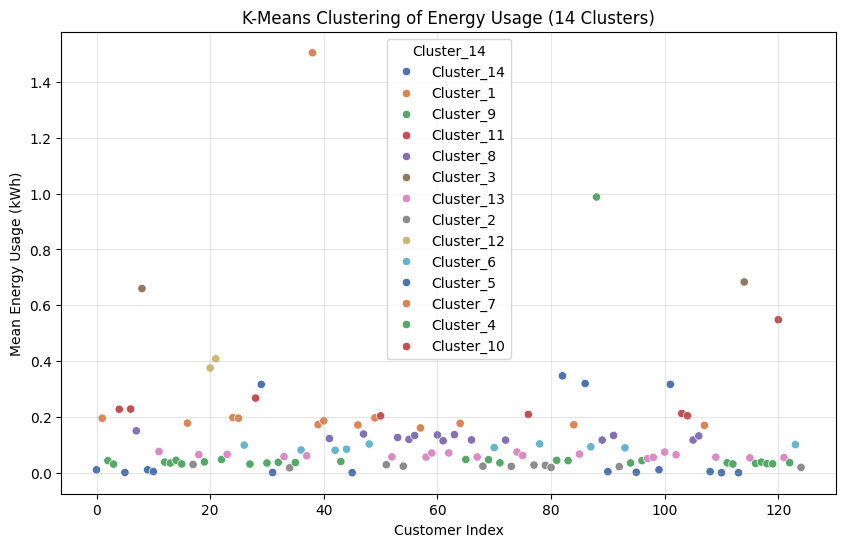


K-Means Clustering (15 clusters):
       Cluster  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  \
0    Cluster_1               9        0.170723        0.150236   
1   Cluster_10               1        0.548185        0.548185   
2   Cluster_11               3        0.241030        0.227489   
3   Cluster_12               2        0.391747        0.375253   
4   Cluster_13              20        0.062378        0.050864   
5   Cluster_14              12        0.004022        0.000115   
6   Cluster_15               8        0.201825        0.195338   
7    Cluster_2              11        0.023695        0.017798   
8    Cluster_3               2        0.671822        0.660106   
9    Cluster_4               1        0.987857        0.987857   
10   Cluster_5               4        0.325001        0.316526   
11   Cluster_6              10        0.092539        0.080621   
12   Cluster_7               1        1.504711        1.504711   
13   Cluster_8              14        0.1

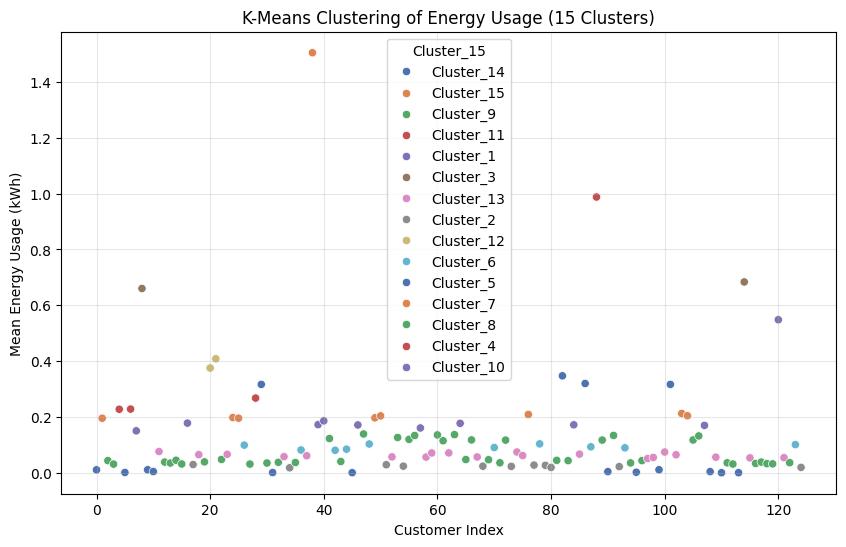

In [ ]:
# Step 5: Run Analysis
print("Quantile-Based Binning Analysis:")
quantile_results, updated_data = analyze_and_bin(customer_energy)

print("\nDGE-Inspired K-Means Clustering Analysis:")
cluster_results = dge_inspired_clustering(updated_data)

In [ ]:
# Step 6: Save Results
updated_data.to_csv('customer_energy_bins.csv', index=False)
print("\nResults saved to 'customer_energy_bins.csv'")


Results saved to 'customer_energy_bins.csv'


In [ ]:

# Step :7 Bid Block Recommendations
def suggest_bid_blocks(results, top_n=5):
    """
    Suggest bid blocks for the top 5 bin sizes in order, based on statistical scores.

    Parameters:
    - results: Dictionary from analyze_and_bin, containing bin_scores and quantile_bins
    - top_n: Number of bin sizes to recommend (default: 5)

    Returns:
    - None (prints ordered recommendations)
    """
    # Sort bin sizes by score (descending)
    bin_scores = results['bin_scores']
    sorted_bins = sorted(bin_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Define ranking labels
    rank_labels = ["First", "Second", "Third", "Fourth", "Fifth"]

    print(f"\nTop {top_n} Bid Block Recommendations (Ordered by Score):")
    for rank, (n_bins, score) in enumerate(sorted_bins, 1):
        quantile_summary = results['quantile_bins'][n_bins]['summary']
        print(f"\n{rank_labels[rank-1]} Recommendation: {n_bins} bins (Score: {score:.4f})")
        print(f"Reason: {'High' if rank == 1 else 'Good' if rank <= 3 else 'Moderate'} score based on low coefficient of variation, minimal energy range overlap, and significant t-test p-values (indicating distinct energy groups).")
        print(quantile_summary)
        for _, row in quantile_summary.iterrows():
            group = row['Group']
            count = row['Customer_Count']
            avg_energy = row['Avg_Energy_kWh']
            min_energy = row['Min_Energy_kWh']
            max_energy = row['Max_Energy_kWh']
            cv = row['CV']
            pricing_guidance = (
                "Low pricing for minimal demand" if avg_energy < results['normal_stats']['mean'] * 0.5 else
                "Moderate pricing for average demand" if avg_energy < results['normal_stats']['mean'] * 1.5 else
                "Premium pricing for high demand"
            )
            print(f"  - {group}: {count} customers, Avg: {avg_energy:.4f} kWh, Range: [{min_energy:.4f}, {max_energy:.4f}] kWh, CV: {cv:.4f}")
            print(f"    - Suggested Bid: {pricing_guidance}. Low CV ({cv:.4f}) indicates stable demand; adjust based on market dynamics and energy market trends.")

# Step 8: Suggest bid blocks for top 5 bin sizes
suggest_bid_blocks(quantile_results)


Top 5 Bid Block Recommendations (Ordered by Score):

First Recommendation: 3 bins (Score: 2852200.6545)
Reason: High score based on low coefficient of variation, minimal energy range overlap, and significant t-test p-values (indicating distinct energy groups).
     Group  Customer_Count  Avg_Energy_kWh  Min_Energy_kWh  Max_Energy_kWh  \
0  Group_1              42        0.023180        0.000115        0.040308   
1  Group_2              41        0.070312        0.043335        0.117100   
2  Group_3              42        0.279900        0.117432        1.504711   

   Std_Energy_kWh        CV  
0        0.013583  0.586008  
1        0.022068  0.313864  
2        0.262757  0.938751  
  - Group_1: 42 customers, Avg: 0.0232 kWh, Range: [0.0001, 0.0403] kWh, CV: 0.5860
    - Suggested Bid: Low pricing for minimal demand. Low CV (0.5860) indicates stable demand; adjust based on market dynamics and energy market trends.
  - Group_2: 41 customers, Avg: 0.0703 kWh, Range: [0.0433, 0.1171] k